In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
from itertools import compress
from Bio import Phylo
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from collections import Counter
import bisect

In [2]:
def read_file(filepath):
	f = open(filepath, 'r')
	lines = f.readlines()
	f.close()
	return lines

def np_save(npz_file_name, np_object):
	f = open(npz_file_name,'wb')
	np.save(f, np_object)
	f.close()

def get_feature_map(drug_coef_array, correlation_idx_array, features_in_seq, corr_idx_shift = 0):
	feat_map = dict()
	weights = drug_coef_array[(correlation_idx_array - corr_idx_shift*np.ones(len(correlation_idx_array))).astype(int)]
	for k, feature_id in enumerate(features_in_seq):
		if(pd.isnull(feature_id)):
			continue
		lsplit = str(feature_id).split()
		[feat_map.update({key: correlation_idx_array[k]}) for key in lsplit]
	return feat_map

def update_weight_dict(weight_dict, feature_map, fasta_record, drug_coef_array, corr_idx_shift = 0):
	feature_coef_index = feature_map.get(fasta_record.id)
	if(pd.isnull(feature_coef_index)):
		return weight_dict
	coef_wt = drug_coef_array[(feature_coef_index - corr_idx_shift).astype(int)]
	if(coef_wt not in weight_dict):
		weight_dict[coef_wt] = [feature_coef_index, fasta_record.description]
	else:
		weight_dict.get(coef_wt).append(fasta_record.description)
	return weight_dict

def generate_seq_feature_matrix(weight_dict, labelled_sequences, drug_index, sort_reverse=False):
	op_matrix = []
	temp = ['Sequences']
	[temp.append(seq) for seq in labelled_sequences]
	op_matrix.append(temp)

	temp = ['Drug_scores']
	[temp.append(score) for score in drug_profile_zip[drug_index][drug_profile_binary_labels[drug_index]==1]]
	op_matrix.append(temp)

	for key, val in sorted(weight_dict.items(), reverse=sort_reverse):
		temp = [key]
		gene_coef_index = int(val[0])
		seq_gene_map = {}
		for v in val[1:]:
			if(v[:6] not in seq_gene_map):
				seq_gene_map[v[:6]] = v.replace(',',';')
			else:
				gene_str = seq_gene_map.get(v[:6]) + '\t' + v.replace(',',';')
				seq_gene_map.update({v[:6]: gene_str})
		for seq in labelled_sequences:
			if(seq in seq_gene_map):
				temp.append(seq_gene_map.get(seq))
			else:
				temp.append('')
		op_matrix.append(temp)
	return op_matrix

In [3]:
lines_gtable = read_file('../Genotypes')

lines_gtable = sorted(lines_gtable)
sequences = np.array([seq.split()[0][:6] for seq in lines_gtable])[1:]

lines_genes_small = read_file('../../Roary/server_plots/available_seq/gene_presence_absence_truncated.csv')

#Compute drug profile matrix for 15 drugs and 350 sequences from Genotypes file
drug_profile_list = []
[drug_profile_list.append(lines_gtable[i].split()[-15:]) for i in range(1,len(lines_gtable))]
drug_profile_list = np.array([[(lambda x: -1 if x=='NA' else int(x))(x) for x in drug] for drug in drug_profile_list])
drug_profile_zip = np.array(list(zip(*drug_profile_list)))

#Only Carbapenem drugs to be considered
carbapenem_drug_profile_zip = drug_profile_zip[[3, 7, 10]]
drug_count = 3#len(drug_profile_zip) - 1

#Convert lines read from gene_presence_absence_truncated csv file into matrix form
genes_pa_small_list = []
#[genes_pa_small_list.append(line[1:-1].split('\n')[0].replace('\t','","').split('","')) for line in lines_genes_small]
[genes_pa_small_list.append(line.replace('"','')[:-1].split(',')) for line in lines_genes_small]
#[genes_pa_small_list.append(re.sub('[^A-Za-z0-9_, ]+', '', line).split(',')) for line in lines_genes_small]
genes_pa_small_list = np.array(genes_pa_small_list)
genes_pa_small_zip = np.array(list(zip(*genes_pa_small_list)))

table = pd.DataFrame.from_csv('../../Roary/server_plots/available_seq/gene_presence_absence_truncated.csv')

#Generate boolean and binary feature matrices for presence-absence of truncated gene set for all 350 sequences
#shape: 350 x 4360 (without column (gene) names)
genes_pa_boolean_list = np.array([[(lambda x: False if x=='' else True)(x) for x in seq_gene] for seq_gene in genes_pa_small_zip[15:]])
genes_pa_boolean_list = genes_pa_boolean_list.T[1:].T
genes_pa_binary_features = np.array([[(lambda x: 1 if x==True else 0)(x) for x in seq_gene] for seq_gene in genes_pa_boolean_list])

drug_profile_median_scores = np.median(drug_profile_zip,axis=1)
drug_profile_binary_labels = np.array([[(lambda x: 1 if x>drug_profile_median_scores[i] else 0)(x) for x in drug_profile] for i, drug_profile in enumerate(drug_profile_zip)])


In [3]:
f = open("../Genotypes",'r')
lines_gtable = f.readlines()
f.close()
lines_gtable = sorted(lines_gtable)

In [30]:
print(lines_gtable[0].split()[-15:])

['Ceftazidime', 'Pip/Tazo', 'Gentamicin', 'Imipenem', 'Amikacin', 'Amp/Sulbactam', 'Trimeth/Sulfa', 'Meropenem', 'Ciprofloxacin', 'Cefepime', 'Doripenem', 'Polymixin_B', 'Tigecycline', 'Tobramycin', 'Tetracycline']


In [27]:
lines_gtable[0]

'Genome\tCluster\tNC_017162_547406\tNC_017162_380765\tNC_017162_3046244\tNC_017162_583607\tNC_017162_2559091\tNC_017162_583601\tNC_017162_547400\tNC_017162_2386579\tNC_017162_2142605\tNC_017162_303112\tNC_017162_3046248\tNC_017162_651915\tNC_017162_2561795\tNC_017162_3056429\tNC_017162_3798804\tNC_017162_1275063\tNC_017162_1978254\tNC_017162_1059747\tNC_017162_1059746\tNC_017162_1275069\tNC_017162_11689\tNC_017162_547403\tNC_017162_3378425\tNC_017162_3633703\tNC_017162_2824164\tNC_017162_3383890\tNC_017162_2028625\tNC_017162_346685\tNC_017162_3313395\tNC_017162_1664851\tNC_017162_2376542\tNC_017162_2376543\tNC_017162_3151908\tNC_017162_1664850\tNC_017162_1343387\tNC_017162_510683\tNC_017162_3850213\tNC_017162_424471\tNC_017162_371593\tNC_017162_3349753\tNC_017162_573475\tNC_017162_3094302\tNC_017162_414264\tNC_017162_414267\tNC_017162_848045\tNC_017162_414261\tNC_017162_547408\tNC_017162_1395822\tNC_017162_431125\tNC_017162_3364107\tNC_017162_3818068\tNC_017162_2457017\tNC_017162_99892

In [3]:
lines_gtable = sorted(lines_gtable)

In [3]:
f = open('lines_gtable_sorted.npz','wb')
np.save(f, lines_gtable)
f.close()

NameError: name 'lines_gtable' is not defined

In [2]:
lines_gtable = np.load('lines_gtable_sorted.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'lines_gtable_sorted.npz'

In [3]:
[print(lines_gtable[i].split()[0], lines_gtable[i].split()[-15:]) for i in range(-10, 0)]

JMOP01.1.fna ['6', '18', '12', '17', '23', '25', '6', 'NA', '6', '17', 'NA', '15', '16', '22', 'NA']
JMOQ01.1.fna ['6', '18', '12', '17', '23', '25', '6', 'NA', '6', '17', 'NA', '15', '16', '22', 'NA']
JMOR01.1.fna ['6', '6', '10', '6', '21', '6', '6', '6', '6', '6', '6', '16', '18', 'NA', 'NA']
JMOT01.1.fna ['6', '12', '6', '17', '11', '12', '6', 'NA', '6', '13', 'NA', '15', '17', '10', 'NA']
JMOU01.1.fna ['6', '16', '6', '16', '21', '24', '6', 'NA', '6', '12', 'NA', '16', '14', '20', 'NA']
JMPB01.1.fna ['9', '6', '6', '9', '26', '8', '6', '6', '6', '12', '6', '16', '20', 'NA', 'NA']
JMPC01.1.fna ['9', '6', '6', '9', '26', '8', '6', '6', '6', '12', '6', '16', '20', 'NA', 'NA']
JMPD01.1.fna ['6', '7', '16', '8', '20', '6', '6', '7', '6', '9', '6', '15', '18', 'NA', 'NA']
JMPE01.1.fna ['6', '8', '8', '17', '23', '18', '6', '12', '6', '7', '11', '15', '17', 'NA', 'NA']
JMPG01.1.fna ['6', '15', '16', '17', '15', '23', '6', '6', '6', '13', '6', '15', '17', 'NA', 'NA']


[None, None, None, None, None, None, None, None, None, None]

In [4]:
[print(len(lines_gtable[i].split())) for i in range(3)]

261103
261103
261103


[None, None, None]

In [19]:
test_lines = ''
for i in range(21):
    test_lines += lines_gtable[i]

In [11]:
f = open('../Genotypes_test_small', 'w+')
f.write(test_lines)
f.close()

In [4]:
f = open("../Genotypes_test_small",'r')
test_lines = f.readlines()
f.close()

In [13]:
print(test_lines[0].split()[-15:])

['Ceftazidime', 'Pip/Tazo', 'Gentamicin', 'Imipenem', 'Amikacin', 'Amp/Sulbactam', 'Trimeth/Sulfa', 'Meropenem', 'Ciprofloxacin', 'Cefepime', 'Doripenem', 'Polymixin_B', 'Tigecycline', 'Tobramycin', 'Tetracycline']


In [19]:
len(test_lines)

21

In [23]:
removedseq = ['JEWW01','JEXZ01','JEZN01','JEXO01','JEWN01','JMNQ01','JFFH01','JFCC01','JFEL01','JEWU01','JFEX01','JMNG01','JEWX01','JEWG01','JMOF01','JEWS01','JMNM01','JFDY01','JEXG01','JEXS01','JEYA01','JFDA01','JEWE01','JEXH01','JEVW01','JMNZ01','JEWP01']

In [24]:
len(removedseq)

27

In [28]:
lines_gtable[1].split()[0][:6] in set(removedseq)

False

In [29]:
for line in lines_gtable:
    lsplit = line.split()
    if(lsplit[0][:6] in set(removedseq)):
        print(lsplit[0], lsplit[-15:])

In [30]:
'JEXZ01' in set(removedseq)

True

In [31]:
len(lines_gtable)

351

In [32]:
allseq = ['JFCY01','JMOB01','JEYH01','JFEV01','JFFE01','JHDB01','JGBH01','JMNP01','JHPI01','JIDA01','JFDD01','JEXZ01','JEWW01','JHPE01','JFDH01','JEXV01','JGBD01','JEZW01','JHCS01','JICP01','JFCU01','JMON01','JEYD01','JFEZ01','JFWF01','JEZO01','JHCK01','JFEB01','JMND01','JGAO01','JEWC01','JEXN01','JMHK01','JFVT01','JFVX01','JGBP01','JMNH01','JGAC01','JEWO01','JEXB01','JMHG01','JEYP01','JFEN01','JFWJ01','JEZC01','JHCG01','JEZZ01','JFFD01','JMOC01','JFCX01','JFEW01','JEYI01','JHPH01','JGAZ01','JMNQ01','JEWV01','JFDE01','JFVA01','JHDC01','JGBI01','JGBE01','JHPD01','JMPG01','JEWZ01','JEXW01','JFDI01','JMOO01','JFCT01','JICQ01','JEYE01','JEZV01','JFFH01','JHCR01','JHOT01','JFEC01','JEZN01','JFWG01','JHCJ01','JFVU01','NC_017162','JGAN01','JMNE01','JMHJ01','JEXO01','JEWB01','JFDQ01','JGAB01','JMNI01','JMHF01','JEXC01','JEWN01','JFVY01','JGBQ01','JFAA01','JEZB01','JFWK01','JHCF01','JFEO01','JEYQ01','JGBJ01','JFVB01','JEXX01','JEWU01','JFDF01','JHPK01','JGAY01','JMNR01','JFET01','JEYJ01','JEZY01','JFFG01','JHCQ01','JEZU01','JFEX01','JMOL01','JICR01','JEXT01','JEWY01','JFDJ01','JMPD01','JHPG01','JGBF01','JMHI01','JEWA01','JEXL01','JFDR01','JGAM01','JMNF01','JFVV01','JHCI01','JEZM01','JFWD01','JHOW01','JMOT01','JFEL01','JEYR01','JFCC01','JHCE01','JEZA01','JFWH01','JGBR01','JFAB01','JFVZ01','JMHE01','JEWM01','JMNJ01','JIDB01','JFDG01','JEWT01','JEXY01','JMNS01','JGAX01','JHPJ01','JGBK01','JHDA01','JFVC01','JFFF01','JEZX01','JEYK01','JFEU01','JFCZ01','JMOA01','JEYG01','JFEY01','JICS01','JFCV01','JMOM01','JHCP01','JFXP01','JEZT01','JGBG01','JFDK01','JEWX01','JEXU01','JHPF01','JMPE01','JFVW01','JFDS01','JEXM01','JMHH01','JMNG01','JGAL01','JFEA01','JMOU01','JHOV01','JHCH01','JFWE01','JEZL01','JHCD01','JFWI01','JEYS01','JFEM01','JHOZ01','JEXA01','JEWL01','JMHD01','JMNK01','JFAC01','JGBS01','JFVH01','JEXR01','JMNX01','JHPA01','JMPB01','JMOJ01','JICT01','JHCW01','JEZS01','JFFA01','JFWV01','JFER01','JEYL01','JMOF01','JICX01','JEWS01','JIDE01','JFUW01','JMNT01','JGBL01','JFVD01','JEXF01','JEWK01','JMHC01','JFDX01','JMNL01','JGAG01','JGBT01','JGCF01','JHCC01','JEZG01','JFWN01','JFEJ01','JEVY01','JFCE01','JFEF01','JEYX01','JMOR01','JHOQ01','JHCO01','JEZK01','JFFU01','JFWB01','JGBX01','JEXJ01','JEWG01','JMHO01','JFDT01','JGAK01','JFUZ01','JEXS01','JMPC01','JGAR01','JMNY01','JGBA01','JFVI01','JHCV01','JEYA01','JICU01','JMOK01','JEYM01','JFES01','JICY01','JMOG01','JHCZ01','JGBM01','JFVE01','JFDA01','JFUV01','JIDD01','JEWR01','JHPL01','JMNU01','JGBU01','JFDY01','JMHB01','JEWJ01','JEXG01','JGAF01','JMNM01','JEYU01','JEVX01','JFEK01','JFCD01','JGCG01','JFWO01','JEZF01','JHCN01','JFWC01','JEZJ01','JEYY01','JFEG01','JHOP01','JFDU01','JMHN01','JEWF01','JEXK01','JGAJ01','JGBY01','JFVQ01','JFCS01','JICV01','JMOH01','JEYB01','JEZQ01','JHCU01','JGBB01','JGAQ01','JMNZ01','JFUY01','JEXP01','JMNV01','JFDB01','JFUU01','JIDG01','JEWQ01','JHDD01','JFVF01','JGBN01','JFFC01','JHCY01','JICZ01','JMOD01','JEYN01','JFEP01','JFWL01','JEZE01','JGCD01','JEYV01','JFEH01','JGAE01','JMNN01','JFDZ01','JMHA01','JEXD01','JEWI01','JGBV01','JGBZ01','JGAI01','JFDV01','JMHM01','JEXH01','JEWE01','JICN01','JMOP01','JEVW01','JEYZ01','JFED01','JEZI01','JHCM01','JGCH01','JEZP01','JHCT01','JICW01','JEYC01','JGAP01','JHPB01','JEXQ01','JFUX01','JGBC01','JFVG01','JHDE01','JGBO01','JMNW01','JEWP01','JIDF01','JFUT01','JFDC01','JMOE01','JFEQ01','JEYO01','JFFB01','JHCX01','JFEI01','JEYW01','JEVZ01','JEZD01','JFWM01','JGCE01','JGBW01','JMNO01','JGAD01','JEWH01','JEXE01','JGAH01','JEWD01','JEXI01','JMHL01','JFDW01','JFVS01','JEZH01','JFWA01','JGCI01','JHCL01','JHOR01','JMOQ01','JICO01','JFEE01','JEVV01']

In [38]:
claderemovalseq = ['JGBT01','JGAG01','JMNL01','JFDX01','JMHC01','JEWK01','JEXF01','JFCE01','JEVY01','JFEJ01','JFWN01','JEZG01','JHCC01','JGCF01','JFWB01','NC_017162','JFFU01','JEZK01','JHCO01','JHOQ01','JMOR01','JEYX01','JFEF01','JGAK01','JFDT01','JMHO01','JEXJ01','JGBX01','JMPB01','JHPA01','JMNX01','JEXR01','JFVH01','JEZS01','JHCW01','JICT01','JMOJ01','JICX01','JEYL01','JFER01','JFWV01','JFFA01','JFVD01','JGBL01','JMNT01','JIDE01','JFUW01','JGAF01','JEWJ01','JMHB01','JGBU01','JEZF01','JFWO01','JGCG01','JFCD01','JFEK01','JEVX01','JEYU01','JHOP01','JFEG01','JEYY01','JEZJ01','JFWC01','JHCN01','JFVQ01','JGBY01','JGAJ01','JEXK01','JEWF01','JMHN01','JFDU01','JFVI01','JGBA01','JMNY01','JGAR01','JMPC01','JFUZ01','JMOK01','JICU01','JHCV01','JHCZ01','JMOG01','JICY01','JFES01','JEYM01','JMNU01','JHPL01','JEWR01','JFUV01','JIDD01','JFVE01','JGBM01','JFEH01','JEYV01','JGCD01','JEZE01','JFWL01','JGBV01','JEWI01','JEXD01','JMHA01','JFDZ01','JMNN01','JGAE01','JMHM01','JFDV01','JGAI01','JGBZ01','JGCH01','JHCM01','JEZI01','JFED01','JEYZ01','JMOP01','JICN01','JHCU01','JEZQ01','JEYB01','JMOH01','JICV01','JFCS01','JEXP01','JFUY01','JGAQ01','JGBB01','JGBN01','JFVF01','JHDD01','JEWQ01','JFUU01','JIDG01','JFDB01','JMNV01','JFEP01','JEYN01','JMOD01','JICZ01','JHCY01','JFFC01','JGCE01','JFWM01','JEZD01','JEVZ01','JEYW01','JFEI01','JEXE01','JEWH01','JGAD01','JMNO01','JGBW01','JFVS01','JFDW01','JMHL01','JEXI01','JEWD01','JGAH01','JEVV01','JFEE01','JICO01','JMOQ01','JHOR01','JHCL01','JGCI01','JFWA01','JEZH01','JEYC01','JICW01','JHCT01','JEZP01','JGBC01','JFUX01','JEXQ01','JGAP01','JHPB01','JFDC01','JIDF01','JFUT01','JMNW01','JGBO01','JHDE01','JFVG01','JHCX01','JFFB01','JEYO01','JFEQ01','JMOE01','JFEB01','JHCK01','JEZO01','JFWF01','JFVT01','JMHK01','JEXN01','JEWC01','JGAO01','JMND01','JMHG01','JEXB01','JEWO01','JGAC01','JMNH01','JGBP01','JFVX01','JHCG01','JEZC01','JFWJ01','JFEN01','JEYP01','JFFE01','JFEV01','JEYH01','JMOB01','JFCY01','JFDD01','JIDA01','JHPI01','JMNP01','JGBH01','JHDB01','JGBD01','JEXV01','JFDH01','JHPE01','JFEZ01','JEYD01','JMON01','JFCU01','JICP01','JHCS01','JEZW01','JHCJ01','JFWG01','JFEC01','JHOT01','JFDQ01','JEWB01','JMHJ01','JMNE01','JGAN01','JFVU01','JFAA01','JGBQ01','JFVY01','JEXC01','JMHF01','JMNI01','JGAB01','JEYQ01','JFEO01','JHCF01','JFWK01','JEZB01','JEYI01','JFEW01','JFCX01','JMOC01','JFFD01','JEZZ01','JGBI01','JHDC01','JFVA01','JFDE01','JEWV01','JHPH01','JGAZ01','JFDI01','JEXW01','JEWZ01','JMPG01','JHPD01','JGBE01','JHCR01','JEZV01','JEYE01','JICQ01','JFCT01','JMOO01','JFVV01','JMNF01','JGAM01','JFDR01','JEXL01','JEWA01','JMHI01','JMOT01','JHOW01','JFWD01','JEZM01','JHCI01','JFWH01','JEZA01','JHCE01','JEYR01','JMNJ01','JEWM01','JMHE01','JFVZ01','JFAB01','JGBR01','JMNR01','JHPK01','JGAY01','JFDF01','JEXX01','JFVB01','JGBJ01','JFFG01','JEZY01','JEYJ01','JFET01','JICR01','JMOL01','JEZU01','JHCQ01','JGBF01','JHPG01','JMPD01','JFDJ01','JEWY01','JEXT01','JGAL01','JMHH01','JEXM01','JFDS01','JFVW01','JEZL01','JFWE01','JHCH01','JHOV01','JMOU01','JFEA01','JHOZ01','JFEM01','JEYS01','JFWI01','JHCD01','JGBS01','JFAC01','JMNK01','JMHD01','JEWL01','JEXA01','JFVC01','JHDA01','JGBK01','JGAX01','JHPJ01','JMNS01','JEXY01','JEWT01','JFDG01','JIDB01','JMOA01','JFCZ01','JFEU01','JEYK01','JEZX01','JFFF01','JEZT01','JFXP01','JHCP01','JMOM01','JFCV01','JICS01','JFEY01','JEYG01','JMPE01','JHPF01','JEXU01','JFDK01','JGBG01']

In [35]:
gtable_seq = set()
for line in lines_gtable[1:]:
    gtable_seq.add(line.split()[0][:6])

In [36]:
len(gtable_seq)

350

In [37]:
set(allseq) - gtable_seq

{'JEVV01',
 'JEVW01',
 'JEVX01',
 'JEVY01',
 'JEVZ01',
 'JEWA01',
 'JEWB01',
 'JEWC01',
 'JEWD01',
 'JEWE01',
 'JEWG01',
 'JEWI01',
 'JEWN01',
 'JEWP01',
 'JEWS01',
 'JEWU01',
 'JEWV01',
 'JEWW01',
 'JEWX01',
 'JEXG01',
 'JEXH01',
 'JEXO01',
 'JEXS01',
 'JEXX01',
 'JEXZ01',
 'JEYA01',
 'JEYB01',
 'JEYJ01',
 'JEYK01',
 'JEZN01',
 'JFCC01',
 'JFDA01',
 'JFDW01',
 'JFDY01',
 'JFEL01',
 'JFEM01',
 'JFEV01',
 'JFEX01',
 'JFFH01',
 'JFVQ01',
 'JMNG01',
 'JMNM01',
 'JMNQ01',
 'JMNY01',
 'JMNZ01',
 'JMOF01',
 'JMOM01',
 'NC_017162'}

In [39]:
set(claderemovalseq) - gtable_seq

{'JEVV01',
 'JEVX01',
 'JEVY01',
 'JEVZ01',
 'JEWA01',
 'JEWB01',
 'JEWC01',
 'JEWD01',
 'JEWI01',
 'JEWV01',
 'JEXX01',
 'JEYB01',
 'JEYJ01',
 'JEYK01',
 'JFDW01',
 'JFEM01',
 'JFEV01',
 'JFVQ01',
 'JMNY01',
 'JMOM01',
 'NC_017162'}

In [40]:
pd.DataFrame.from_csv('../Genotypes_test_small', sep='\t')

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2831: DtypeWarning: Columns (6,11,14,18,19,20,26,28,34,43,44,45,47,53,54,55,59,63,66,72,74,78,81,82,84,85,86,89,90,91,95,97,99,101,102,103,104,105,106,108,111,116,117,118,128,130,131,132,142,143,145,147,149,156,160,162,165,170,172,173,175,176,181,182,183,189,192,194,197,203,205,206,211,212,221,234,236,239,241,242,243,245,246,248,252,253,254,257,258,261,262,264,267,275,276,281,286,287,302,304,306,308,309,311,313,314,316,319,321,322,323,324,325,327,329,330,331,333,334,339,346,347,348,357,358,363,364,365,366,370,379,380,381,392,398,400,401,403,404,405,407,413,418,419,423,427,432,434,435,439,441,442,447,451,454,455,458,460,461,463,465,466,468,469,472,475,481,482,488,490,491,493,494,495,496,497,498,499,500,501,503,504,505,506,510,523,524,526,527,528,529,531,533,536,543,547,548,549,550,554,557,560,564,565,566,573,574,576,577,583,584,585,591,592,593,595,600,601,604,607,609,611,613,635,639,640,642,643,644,645,646,649,650,6

Cluster NC_017162_547406 NC_017162_380765 NC_017162_3046244  \
Genome                                                                      
JHCE01.1.fna       14                T                C                 G   
JFVW01.1.fna       13                T                C                 G   
JFVY01.1.fna       13                T                C                 G   
JFDC01.1.fna       13                T                C                 G   
JEXW01.1.fna       15                T                C                 A   
JEYQ01.1.fna       12                T                C                 G   
JHPB01.1.fna       14                T                C                 G   
JMHH01.1.fna       15                T                C                 A   
JFDR01.1.fna       21                T                C                 G   
JMOP01.1.fna       13                T                C                 G   
JICO01.1.fna       16                T                C                 G   
JGAO01.1.fna       12                T                C                 G   
JMNI01.1.fna       12                T                C                 G   
JGBU01.1.fna       14                T                C                 G   
JEYD01.1.fna       17                C                C                 C   
JEWM01.1.fna       19                T                A                 A   
JEYS01.1.fna       15                T                C                 A   
JFEA01.1.fna       16                T                C                 G   
JEYH01.1.fna       21                T                A                 G   
JEZO01.1.fna       11                T                C                 G   

             NC_017162_583607 NC_017162_2559091 NC_017162_583601  \
Genome                                                             
JHCE01.1.fna                C               NaN                G   
JFVW01.1.fna                C               NaN                G   
JFVY01.1.fna                C               NaN                G   
JFDC01.1.fna                C               NaN                G   
JEXW01.1.fna                C                 C                G   
JEYQ01.1.fna                C               NaN                G   
JHPB01.1.fna                C               NaN                G   
JMHH01.1.fna                C                 C                G   
JFDR01.1.fna                C               NaN                G   
JMOP01.1.fna                C               NaN                G   
JICO01.1.fna                C               NaN                G   
JGAO01.1.fna                C               NaN                G   
JMNI01.1.fna                C               NaN                G   
JGBU01.1.fna                C               NaN                G   
JEYD01.1.fna                C               NaN                C   
JEWM01.1.fna              NaN               NaN              NaN   
JEYS01.1.fna                C                 C                G   
JFEA01.1.fna                C               NaN                G   
JEYH01.1.fna                C               NaN                G   
JEZO01.1.fna              NaN               NaN              NaN   

             NC_017162_547400 NC_017162_2386579 NC_017162_2142605  \
Genome                                                              
JHCE01.1.fna                T               NaN                 G   
JFVW01.1.fna                T                 T                 G   
JFVY01.1.fna                T                 T                 G   
JFDC01.1.fna                T                 T                 G   
JEXW01.1.fna                T                 C                 G   
JEYQ01.1.fna                T                 T                 G   
JHPB01.1.fna                T               NaN                 G   
JMHH01.1.fna                T                 C                 G   
JFDR01.1.fna                T                 T                 G   
JMOP01.1.fna                T                 T                

In [10]:
for line in test_lines:
    lsplit = line.split()
    if(lsplit[-15]=='6'):
        print(lsplit[0], lsplit[-15:])

JEWJ01.1.fna ['6', '6', '23', '7', '15', '6', '6', '6', '6', '10', '6', '16', '17', 'NA', 'NA']
JEWK01.1.fna ['6', '6', '20', '6', '12', '6', '6', '6', '6', '8', '6', '15', '21', 'NA', 'NA']
JEWR01.1.fna ['6', '7', '7', '10', '21', '14', '6', '8', '6', '8', '6', '15', '16', 'NA', 'NA']
JEWT01.1.fna ['6', '6', '20', '6', '21', '6', '6', '6', '6', '6', '6', '15', '20', 'NA', 'NA']
JEXA01.1.fna ['6', '6', '20', '6', '27', '14', '20', '6', '6', '6', '6', '15', '20', 'NA', 'NA']
JEXE01.1.fna ['6', '6', '25', '6', '26', '6', '6', '6', '6', '6', '6', '15', '16', 'NA', 'NA']
JEXF01.1.fna ['6', '7', '7', '7', '23', '7', '6', '6', '6', '10', '6', '16', '16', 'NA', 'NA']


In [4]:
f = open('../../Roary/server_plots/available_seq/gene_presence_absence.csv')
lines_genes_pa = f.readlines()
f.close()

In [17]:
test_list = []
for line in lines_genes_pa[1:]:
    lsplit = line[1:-1].split('\n')[0].split('","')
    if(int(lsplit[3])>=70):
        test_list.append(line)
print(len(test_list))

4360


In [47]:
f = open('../../Roary/server_plots/available_seq/gene_presence_absence_truncated.csv', 'w+')
f.write(lines_genes_pa[0])
[f.write(line) for line in test_list]
f.close()

In [4]:
f = open('../../Roary/server_plots/available_seq/gene_presence_absence_truncated.csv')
lines_genes_small = f.readlines()
f.close()

In [12]:
len(lines_genes_small)

4361

In [51]:
drug_profiles = [[] for i in range(15)]

In [5]:
drug_profile_list = []
[drug_profile_list.append(lines_gtable[i].split()[-15:]) for i in range(1,len(lines_gtable))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [6]:
drug_profile_list = np.array([[(lambda x: -1 if x=='NA' else int(x))(x) for x in drug] for drug in drug_profile_list])

In [6]:
len(list(zip(*drug_profile_list))[0])

350

In [ ]:
list(compress(lines_gtable, list(zip(*drug_profile_list))[0] == np.unique(list(zip(*drug_profile_list))[0])[0]))

In [156]:
test_lines_sorted = sorted(test_lines)

In [20]:
test_drug_profile_list = []
[test_drug_profile_list.append(test_lines[i].split()[-15:]) for i in range(1,len(test_lines))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [21]:
test_drug_profile_list = [[(lambda x: -1 if x=='NA' else int(x))(x) for x in drug] for drug in test_drug_profile_list]

ValueError: invalid literal for int() with base 10: 'e'

In [ ]:
len(list(zip(*test_drug_profile_list))[0])

In [30]:
len(np.insert(list(zip(*test_drug_profile_list))[0] == np.unique(list(zip(*test_drug_profile_list))[0])[0], 0, True))

21

In [31]:
temp = list(compress(test_lines, np.insert(list(zip(*test_drug_profile_list))[0] == np.unique(list(zip(*test_drug_profile_list))[0])[0], 0, True)))

In [32]:
len(temp)

8

In [33]:
[t.split()[0] for t in temp]

['Genome',
 'JEWJ01.1.fna',
 'JEWK01.1.fna',
 'JEWR01.1.fna',
 'JEWT01.1.fna',
 'JEXA01.1.fna',
 'JEXE01.1.fna',
 'JEXF01.1.fna']

In [ ]:
drug_0_profile = list(zip(*test_drug_profile_list))[0]
#indices of sequences with a particular drug resistance value for the chosen drug
#(insertion used to add the header and maintain the row numbers for the sequences)
seq_indices = drug_0_profile == np.unique(drug_0_profile)[0]
#drug_0_res_i = list(compress(test_lines, np.insert(seq_indices, 0, True)))
#drug_0_res_i_seq = [seq.split()[0][:6] for seq in drug_0_res_i[1:]]

In [15]:
drug_0_res_i_seq

['JEWJ01', 'JEWK01', 'JEWR01', 'JEWT01', 'JEXA01', 'JEXE01', 'JEXF01']

In [7]:
genes_pa_small_list = []
[genes_pa_small_list.append(line[1:-1].split('\n')[0].split('","')) for line in lines_genes_small]
genes_pa_small_list = np.array(genes_pa_small_list)

In [18]:
len(test_drug_profile_list), len(seq_indices)

(20, 20)

In [20]:
np.array(test_drug_profile_list)[np.array(seq_indices)]

array([[ 6,  6, 23,  7, 15,  6,  6,  6,  6, 10,  6, 16, 17, -1, -1],
       [ 6,  6, 20,  6, 12,  6,  6,  6,  6,  8,  6, 15, 21, -1, -1],
       [ 6,  7,  7, 10, 21, 14,  6,  8,  6,  8,  6, 15, 16, -1, -1],
       [ 6,  6, 20,  6, 21,  6,  6,  6,  6,  6,  6, 15, 20, -1, -1],
       [ 6,  6, 20,  6, 27, 14, 20,  6,  6,  6,  6, 15, 20, -1, -1],
       [ 6,  6, 25,  6, 26,  6,  6,  6,  6,  6,  6, 15, 16, -1, -1],
       [ 6,  7,  7,  7, 23,  7,  6,  6,  6, 10,  6, 16, 16, -1, -1]])

In [21]:
test_drug_profile_list = np.array(test_drug_profile_list)
seq_indices = np.array(seq_indices)

In [7]:
sequences = np.array([seq.split()[0][:6] for seq in test_lines])[1:]
sequences[:5]

NameError: name 'test_lines' is not defined

In [24]:
sequences[seq_indices]

array(['JEWJ01', 'JEWK01', 'JEWR01', 'JEWT01', 'JEXA01', 'JEXE01', 'JEXF01'], 
      dtype='<U6')

In [71]:
list(zip(sequences[seq_indices], np.array(drug_0_profile)[seq_indices]))

[('JEWJ01', 6),
 ('JEWK01', 6),
 ('JEWR01', 6),
 ('JEWT01', 6),
 ('JEXA01', 6),
 ('JEXE01', 6),
 ('JEXF01', 6)]

In [21]:
genes_pa_small_list = np.array(genes_pa_small_list)

In [42]:
[(seq.split()[0][:6], seq.split()[-15]) for seq in sorted(drug_0_res_i[1:])]

[('JEWJ01', '6'),
 ('JEWK01', '6'),
 ('JEWR01', '6'),
 ('JEWT01', '6'),
 ('JEXA01', '6'),
 ('JEXE01', '6'),
 ('JEXF01', '6')]

In [11]:
list(zip(*genes_pa_small_list))[0][:10]

('Gene',
 'mepA',
 'yciC',
 'group_10125',
 'folC',
 'group_10229',
 'group_10232',
 'group_10233',
 'group_10518',
 'moaE1')

In [22]:
req_col_extended = np.append(np.zeros(14), seq_indices)
req_col_extended = np.append(req_col_extended, np.zeros(len(genes_pa_small_list[0])-len(req_col_extended)))
req_col_extended = np.array([(lambda x: True if x==1 else False)(x) for x in req_col_extended])
req_col_extended[0] = True

NameError: name 'seq_indices' is not defined

In [46]:
genes_pa_small_list[0][req_col_extended]

array(['Gene', 'JEWJ01', 'JEWK01', 'JEWR01', 'JEWT01', 'JEXA01', 'JEXE01',
       'JEXF01'], 
      dtype='<U519')

In [48]:
seq_all_genes = np.array(list(zip(*genes_pa_small_list)))[req_col_extended]
print(len(seq_all_genes), len(seq_all_genes[0]))

8 4361


In [51]:
seq_all_genes[1][-1]==''

True

In [54]:
seq_common_genes = []
for gene in list(zip(*seq_all_genes))[1200:1220]:
    print(gene[:5])

('group_33021', 'JEWJ01_00149', 'JEWK01_00795', 'JEWR01_00372', 'JEWT01_02273')
('murF', 'JEWJ01_00198', 'JEWK01_00844', 'JEWR01_00323', 'JEWT01_02487')
('mlaE', 'JEWJ01_00897', 'JEWK01_01402', 'JEWR01_00420', 'JEWT01_01652')
('rplR', 'JEWJ01_00859', 'JEWK01_01440', 'JEWR01_00458', 'JEWT01_01690')
('group_33275', 'JEWJ01_02895', 'JEWK01_03492', 'JEWR01_02867', 'JEWT01_03481')
('astD', 'JEWJ01_02620', 'JEWK01_00777', 'JEWR01_00390', 'JEWT01_02291')
('oatA', 'JEWJ01_00274', 'JEWK01_00619', '', 'JEWT01_01157')
('secA', 'JEWJ01_01696', 'JEWK01_01672', 'JEWR01_01421', 'JEWT01_01812')
('valS', 'JEWJ01_01538', 'JEWK01_02031', 'JEWR01_02197', 'JEWT01_02131')
('cat_2', 'JEWJ01_03763', 'JEWK01_01592', 'JEWR01_03317', 'JEWT01_03503')
('plsB', 'JEWJ01_00886', 'JEWK01_01413', 'JEWR01_00431', 'JEWT01_01663')
('alkB', 'JEWJ01_02791', 'JEWK01_00988', 'JEWR01_00588', 'JEWT01_01245')
('menH_1', 'JEWJ01_00498', '', 'JEWR01_00094', 'JEWT01_01056')
('nuoG', 'JEWJ01_01848', 'JEWK01_01869', 'JEWR01_00804', '

In [22]:
for gene in list(zip(*seq_all_genes))[1200:1220]:
    row_sum = np.sum(np.array([(lambda x: 1 if x=='' else 0)(x) for x in gene]))
    if(row_sum==0):
        seq_common_genes.append(gene[0])

NameError: name 'seq_all_genes' is not defined

In [57]:
seq_common_genes

['group_33021',
 'murF',
 'mlaE',
 'rplR',
 'group_33275',
 'astD',
 'secA',
 'valS',
 'cat_2',
 'plsB',
 'alkB',
 'nuoG',
 'group_5957',
 'dnaJ',
 'group_6076',
 'ptsI',
 'group_6206',
 'yclQ_1']

In [6]:
drug_profile_zip = np.load('drug_profile_zip.npz')
print(drug_profile_zip.shape)

(15, 350)


In [14]:
drug_profile_zip = np.array(list(zip(*drug_profile_list)))
drug_profile_zip.shape

(15, 350)

In [62]:
seq_common_genes_indices = []
all_gene_row_list = list(zip(*seq_all_genes))[1:] #removing the header
for idx, gene in enumerate(all_gene_row_list):
    row_sum = np.sum(np.array([(lambda x: 1 if x=='' else 0)(x) for x in gene]))
    if(row_sum==0):
        seq_common_genes_indices.append(idx+1)
seq_common_genes_indices = np.array(seq_common_genes_indices)
print(len(seq_common_genes_indices))

2295


In [ ]:
drug_profile_zip = list(zip(*drug_profile_list))
#indices of sequences with a particular drug resistance value for the chosen drug
#(insertion used to add the header and maintain the row numbers for the sequences)
for drug_profile in drug_profile_zip:
    op_common_seq_idx_str += str(len(np.unique(drug_profile))) + '\n'
    
    for profile in np.unique(drug_profile):
        seq_indices = np.array(drug_profile == profile)
        print('seq_indices: ', seq_indices)
        print(list(zip(sequences[seq_indices], np.array(drug_profile)[seq_indices])))
        
        for idx in seq_indices:
            op_common_seq_idx_str += str(idx) + '\t'
        op_common_seq_idx_str += '\n'

In [60]:
for i, gene in enumerate(seq_common_genes[1:]):
    print(i, gene)

0 murF
1 mlaE
2 rplR
3 group_33275
4 astD
5 secA
6 valS
7 cat_2
8 plsB
9 alkB
10 nuoG
11 group_5957
12 dnaJ
13 group_6076
14 ptsI
15 group_6206
16 yclQ_1


In [9]:
f = open("../drug_profile_indices",'r')
line_drug_pf_idx = f.readlines()
f.close()

In [10]:
unique_drug_resistance_count = 0
drug_idx_str = ''
drug_idx_list = []
for line in line_drug_pf_idx:
    lsplit = line.split()
    if(len(lsplit)==1):
        if(drug_idx_str != ''):
            drug_idx_list.append(drug_idx_str)
        unique_drug_resistance_count = lsplit[0]
        drug_idx_str = ''
    else:
        drug_idx_str += line   
drug_idx_list.append(drug_idx_str)

In [12]:
len(drug_idx_list)

15

In [8]:
#lines_gtable = sorted(lines_gtable)
sequences = np.array([seq.split()[0][:6] for seq in lines_gtable])[1:]
#drug_profile_zip = list(zip(*drug_profile_list))

In [12]:
drug_seq_table = []
for drug_profile in drug_profile_zip:
    drug_seq_subtable = []
    for profile in np.unique(drug_profile):
        seq_indices = np.array(drug_profile == profile)
        drug_seq_subtable.append(np.array(seq_indices))
    drug_seq_table.append(np.array(drug_seq_subtable))
drug_seq_table = np.array(drug_seq_table)

In [22]:
drug_seq_table.shape

(15,)

In [106]:
f = open('drug_seq_table.npz','wb')
np.save(f, drug_seq_table)
f.close()

In [9]:
drug_seq_table = np.load('drug_seq_table.npz')
drug_seq_table.shape

(15,)

In [13]:
drug_gene_table = []
for drug_index_list in drug_idx_list:
    #split for gene indices for each unique drug resistance for chosen drug
    drug_idx_lsplit = drug_index_list.split('\n')
    print(len(drug_idx_lsplit)) #tab separated lists corresponding to each drug resistance value and 1 '' string
    drug_gene_subtable = []
    for drug_lsplit in drug_idx_lsplit[:-1]:
        temp = []
        dlsplit = drug_lsplit.split()
        [temp.append(int(val)) for val in dlsplit]
        drug_gene_subtable.append(np.array(temp))
    drug_gene_table.append(np.array(drug_gene_subtable))

drug_gene_table = np.array(drug_gene_table)
print(drug_gene_table.shape)

20
24
22
26
24
28
13
24
14
26
25
14
19
13
3
(15,)


In [16]:
list(zip(*genes_pa_small_list))[0]

('Gene',
 'mepA',
 'yciC',
 'group_10125',
 'folC',
 'group_10229',
 'group_10232',
 'group_10233',
 'group_10518',
 'moaE1',
 'yybR_1',
 'group_11140',
 'group_11184',
 'chbG',
 'cobP',
 'group_11350',
 'group_11415',
 'group_11462',
 'group_11474',
 'serS',
 'group_11529',
 'group_11533',
 'trpB_1',
 'group_11567',
 'group_11579',
 'group_11597',
 'group_11665',
 'rpmH',
 'gyrB',
 'group_11819',
 'cydA_2',
 'msrA',
 'group_12357',
 'ahcY',
 'leuS',
 'rodZ',
 'bcrC',
 'nagZ',
 'group_12763',
 'yddE_1',
 'xerC_1',
 'group_12797',
 'bioA',
 'group_13005',
 'group_13064',
 'group_13070',
 'group_13104',
 'sdhA',
 'lptG',
 'group_13166',
 'acm',
 'group_13199',
 'ftsN_1',
 'group_13232',
 'mutM',
 'group_13244',
 'esiB_3',
 'hmrR_1',
 'group_13478',
 'group_13483',
 'trxC',
 'group_13504',
 'rimI',
 'proA_1',
 'clpX',
 'metX',
 'mnmA',
 'group_14504',
 'ygiF',
 'group_14507',
 'group_14510',
 'purN',
 'group_14532',
 'group_14546',
 'group_14548',
 'group_14550',
 'qseB_1',
 'aroF_1',
 'r

In [14]:
[len(row) for row in drug_gene_table]

[19, 23, 21, 25, 23, 27, 12, 23, 13, 25, 24, 13, 18, 12, 2]

In [56]:
[len(row) for sub in drug_gene_table for row in sub]

[619,
 3167,
 3082,
 2173,
 2610,
 2594,
 3651,
 2911,
 2805,
 2953,
 1825,
 1886,
 1724,
 2240,
 1841,
 2587,
 2619,
 1965,
 2208,
 895,
 1714,
 1365,
 2171,
 1843,
 1831,
 2854,
 2060,
 2226,
 1677,
 2333,
 2576,
 1938,
 2622,
 2255,
 1831,
 2476,
 2030,
 2652,
 2111,
 2205,
 2217,
 2379,
 1048,
 1968,
 1697,
 1717,
 1763,
 2136,
 2060,
 2548,
 2665,
 2414,
 2084,
 2052,
 1956,
 1767,
 1578,
 1894,
 1694,
 1695,
 1632,
 1998,
 2576,
 1246,
 1447,
 1408,
 1302,
 1728,
 2378,
 3446,
 3273,
 2405,
 1811,
 1796,
 3212,
 3194,
 3137,
 2687,
 1917,
 2098,
 1838,
 1789,
 2199,
 2431,
 3268,
 2382,
 3016,
 2685,
 2359,
 2401,
 2271,
 2348,
 1761,
 2196,
 2381,
 2131,
 1963,
 1653,
 2917,
 2719,
 2745,
 2134,
 1936,
 1518,
 1256,
 1322,
 1425,
 1685,
 1527,
 2030,
 2974,
 1140,
 2975,
 1685,
 2315,
 2041,
 1856,
 2002,
 2108,
 2192,
 1614,
 2563,
 1807,
 2207,
 2188,
 2419,
 2741,
 2269,
 1678,
 1832,
 1658,
 1794,
 2271,
 2041,
 2369,
 1937,
 2685,
 2576,
 566,
 2091,
 2716,
 2018,
 1983,
 2

In [57]:
set(drug_gene_table[0][-1]) - set(drug_gene_table[0][-2])

{485,
 525,
 531,
 580,
 658,
 687,
 721,
 723,
 774,
 783,
 785,
 798,
 833,
 839,
 860,
 882,
 904,
 909,
 928,
 931,
 944,
 945,
 970,
 978,
 983,
 998,
 999,
 1002,
 1006,
 1010,
 1011,
 1030,
 1033,
 1036,
 1074,
 1095,
 1099,
 1106,
 1108,
 1125,
 1129,
 1142,
 1147,
 1149,
 1158,
 1173,
 1206,
 1208,
 1216,
 1223,
 1234,
 1238,
 1240,
 1248,
 1251,
 1256,
 1262,
 1265,
 1267,
 1288,
 1291,
 1294,
 1298,
 1302,
 1312,
 1313,
 1334,
 1337,
 1341,
 1342,
 1347,
 1356,
 1358,
 1362,
 1367,
 1368,
 1372,
 1386,
 1389,
 1392,
 1396,
 1401,
 1402,
 1411,
 1413,
 1414,
 1415,
 1419,
 1436,
 1441,
 1444,
 1447,
 1452,
 1457,
 1461,
 1463,
 1467,
 1481,
 1482,
 1489,
 1491,
 1494,
 1508,
 1520,
 1522,
 1524,
 1526,
 1528,
 1529,
 1534,
 1537,
 1538,
 1549,
 1554,
 1556,
 1561,
 1563,
 1565,
 1571,
 1577,
 1581,
 1583,
 1597,
 1614,
 1615,
 1616,
 1639,
 1656,
 1661,
 1663,
 1665,
 1666,
 1667,
 1668,
 1671,
 1672,
 1675,
 1678,
 1684,
 1692,
 1710,
 1716,
 1717,
 1731,
 1733,
 1745,
 1758

In [14]:
np.array(lines_gtable[0].split()[-15:])

array(['Ceftazidime', 'Pip/Tazo', 'Gentamicin', 'Imipenem', 'Amikacin',
       'Amp/Sulbactam', 'Trimeth/Sulfa', 'Meropenem', 'Ciprofloxacin',
       'Cefepime', 'Doripenem', 'Polymixin_B', 'Tigecycline', 'Tobramycin',
       'Tetracycline'], 
      dtype='<U13')

In [18]:
[np.unique(profile) for profile in list(zip(*drug_profile_list))]

[array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24,
        25, 27]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 28, 29]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 27]),
 array([ 6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 22, 23, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 35, 36, 37]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 32]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29, 30, 32, 33]),
 array([ 6, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
 array([-1,  6,  7,  8,  9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23,
        24, 25, 26, 27, 28, 30]),
 array([ 6, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 26, 27, 28, 29

In [20]:
for sub in drug_seq_table:
    print([len(sequences[idx]) for idx in sub])

[276, 2, 2, 6, 6, 2, 1, 2, 3, 1, 6, 12, 7, 6, 8, 2, 1, 5, 2]
[113, 20, 40, 15, 14, 27, 9, 14, 9, 18, 10, 8, 15, 2, 4, 7, 3, 7, 2, 5, 4, 2, 2]
[82, 17, 29, 28, 19, 6, 16, 3, 2, 3, 13, 7, 17, 19, 39, 7, 10, 11, 15, 6, 1]
[53, 44, 46, 50, 28, 3, 1, 1, 10, 29, 41, 1, 1, 1, 2, 6, 7, 5, 9, 3, 4, 1, 2, 1, 1]
[12, 14, 11, 10, 10, 13, 8, 14, 9, 14, 2, 8, 2, 11, 12, 35, 39, 41, 18, 32, 30, 4, 1]
[61, 5, 22, 16, 9, 10, 21, 15, 5, 27, 2, 8, 5, 5, 16, 11, 14, 24, 18, 30, 8, 3, 6, 2, 5, 1, 1]
[306, 5, 2, 5, 4, 2, 6, 5, 4, 3, 4, 4]
[120, 118, 22, 19, 1, 14, 7, 4, 3, 1, 1, 2, 2, 5, 4, 6, 3, 6, 3, 3, 1, 3, 2]
[318, 1, 1, 1, 3, 1, 5, 5, 5, 1, 4, 4, 1]
[70, 10, 14, 9, 24, 11, 72, 28, 17, 26, 3, 16, 13, 2, 4, 5, 6, 3, 5, 3, 3, 2, 2, 1, 1]
[121, 101, 40, 12, 2, 15, 8, 6, 1, 1, 1, 1, 1, 2, 4, 2, 1, 6, 5, 5, 3, 5, 2, 5]
[1, 1, 11, 8, 44, 154, 112, 12, 2, 2, 1, 1, 1]
[2, 2, 10, 5, 16, 13, 87, 81, 40, 21, 43, 8, 2, 9, 5, 3, 2, 1]
[230, 3, 1, 8, 1, 7, 1, 12, 32, 27, 16, 12]
[349, 1]


In [19]:
for sub in drug_gene_table:
    print([len(genes) for genes in sub])

[619, 3167, 3082, 2173, 2610, 2594, 3651, 2911, 2805, 2953, 1825, 1886, 1724, 2240, 1841, 2587, 2619, 1965, 2208]
[895, 1714, 1365, 2171, 1843, 1831, 2854, 2060, 2226, 1677, 2333, 2576, 1938, 2622, 2255, 1831, 2476, 2030, 2652, 2111, 2205, 2217, 2379]
[1048, 1968, 1697, 1717, 1763, 2136, 2060, 2548, 2665, 2414, 2084, 2052, 1956, 1767, 1578, 1894, 1694, 1695, 1632, 1998, 2576]
[1246, 1447, 1408, 1302, 1728, 2378, 3446, 3273, 2405, 1811, 1796, 3212, 3194, 3137, 2687, 1917, 2098, 1838, 1789, 2199, 2431, 3268, 2382, 3016, 2685]
[2359, 2401, 2271, 2348, 1761, 2196, 2381, 2131, 1963, 1653, 2917, 2719, 2745, 2134, 1936, 1518, 1256, 1322, 1425, 1685, 1527, 2030, 2974]
[1140, 2975, 1685, 2315, 2041, 1856, 2002, 2108, 2192, 1614, 2563, 1807, 2207, 2188, 2419, 2741, 2269, 1678, 1832, 1658, 1794, 2271, 2041, 2369, 1937, 2685, 2576]
[566, 2091, 2716, 2018, 1983, 2646, 1801, 2032, 2071, 2265, 2042, 2211]
[965, 874, 1996, 2103, 3446, 2481, 2766, 2578, 3395, 2875, 3212, 2647, 2546, 1998, 2332, 2208, 2

In [21]:
for sub in drug_gene_table:
    common_genes_drug0 = set(sub[0])
    temp = [len(common_genes_drug0)]
    for genes in sub[1:]:
        common_genes_drug0 = common_genes_drug0.intersection(set(genes))
        temp.append(len(common_genes_drug0))
    print(temp)

[619, 619, 616, 601, 584, 583, 583, 583, 581, 580, 564, 545, 527, 509, 496, 492, 482, 474, 467]
[895, 806, 686, 682, 666, 643, 641, 625, 621, 590, 573, 570, 559, 559, 543, 515, 514, 506, 503, 492, 484, 479, 467]
[1048, 997, 929, 858, 789, 765, 738, 736, 732, 722, 698, 685, 663, 635, 595, 571, 551, 508, 481, 471, 467]
[1246, 957, 807, 672, 647, 641, 641, 639, 629, 595, 570, 569, 569, 564, 564, 549, 540, 520, 497, 490, 479, 478, 474, 470, 467]
[2359, 1882, 1616, 1527, 1256, 1193, 1125, 1057, 986, 862, 861, 829, 827, 805, 781, 717, 604, 561, 531, 511, 489, 478, 467]
[1140, 1133, 966, 933, 917, 854, 810, 760, 749, 703, 687, 663, 649, 642, 636, 634, 619, 587, 562, 542, 520, 506, 494, 491, 474, 471, 467]
[566, 554, 549, 527, 521, 518, 496, 493, 488, 483, 472, 467]
[965, 616, 580, 578, 578, 571, 568, 562, 562, 556, 555, 555, 546, 529, 516, 511, 509, 492, 489, 484, 483, 474, 467]
[551, 549, 545, 545, 533, 529, 513, 499, 489, 489, 477, 470, 467]
[1240, 1140, 1082, 1041, 865, 826, 652, 611, 609,

In [24]:
ref_seq_gene_indices = np.array([idx+1 for idx, gene in enumerate(np.array(list(zip(*genes_pa_small_list)))[-1][1:]) if gene != '"'])
ref_seq_gene_indices

array([   1,    2,    3, ..., 4347, 4353, 4357])

In [25]:
len(ref_seq_gene_indices)

3257

In [26]:
for sub in drug_gene_table:
    print([len(set(genes) - set(ref_seq_gene_indices)) for genes in sub])

[0, 165, 187, 38, 84, 192, 671, 240, 206, 266, 19, 67, 55, 95, 41, 189, 286, 34, 154]
[1, 23, 6, 30, 25, 18, 68, 37, 31, 18, 50, 81, 33, 123, 116, 68, 161, 76, 181, 81, 55, 96, 216]
[1, 34, 19, 20, 21, 37, 29, 93, 128, 89, 68, 32, 24, 11, 18, 30, 20, 24, 19, 32, 262]
[4, 11, 9, 6, 17, 83, 422, 318, 156, 17, 16, 225, 220, 521, 83, 67, 92, 70, 41, 135, 153, 321, 158, 292, 234]
[193, 65, 75, 71, 20, 38, 54, 44, 28, 21, 136, 280, 202, 32, 13, 11, 9, 8, 8, 18, 10, 61, 283]
[5, 282, 22, 54, 30, 19, 23, 42, 56, 13, 108, 17, 45, 45, 139, 94, 45, 23, 15, 17, 56, 117, 63, 82, 71, 234, 262]
[0, 46, 95, 40, 34, 175, 32, 58, 114, 108, 37, 78]
[2, 1, 37, 25, 422, 177, 210, 78, 466, 242, 225, 105, 194, 85, 133, 106, 123, 79, 138, 150, 220, 76, 154]
[0, 314, 253, 294, 127, 224, 127, 69, 95, 270, 32, 103, 234]
[4, 29, 37, 48, 8, 36, 3, 11, 38, 25, 59, 32, 21, 94, 72, 112, 69, 131, 85, 147, 55, 134, 136, 262, 234]
[1, 1, 10, 33, 137, 68, 70, 415, 376, 297, 585, 225, 220, 199, 121, 166, 294, 107, 76, 102

In [156]:
tree = Phylo.read('../../Roary/server_plots/available_seq/accessory_binary_genes.fa.newick', 'newick')

In [158]:
# Max distance to create better plots
mdist = max([tree.distance(tree.root, x) for x in tree.get_terminals()])

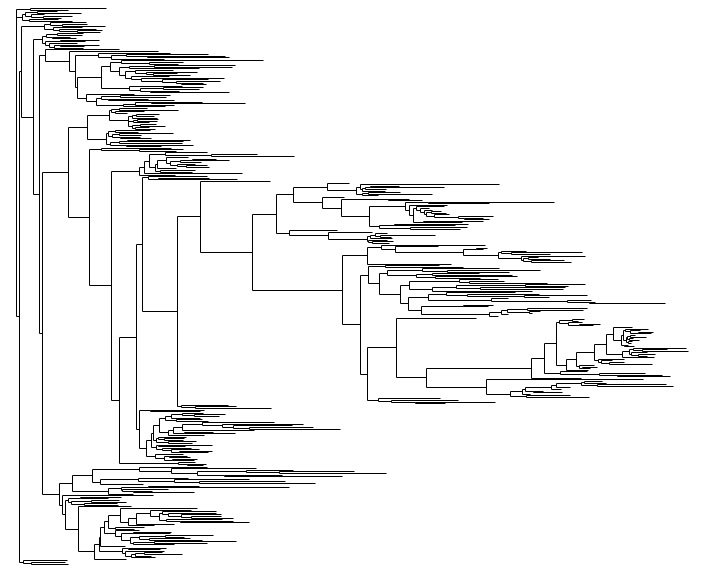

In [164]:
fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(1,2,1)
ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')
Phylo.draw(tree, axes=ax,
           show_confidence=False,
           label_func=lambda x: None,
           xticks=([],), yticks=([],),
           ylabel=('',), xlabel=('',),
           xlim=(-0.01,mdist+0.01),
           axis=('off',),
           )

In [9]:
genes_pa_small_zip = np.array(list(zip(*genes_pa_small_list)))
genes_pa_small_zip[0]

array(['Gene', 'mepA', 'yciC', ..., 'group_6711', 'group_7239',
       'group_7874'], 
      dtype='<U519')

In [10]:
genes_pa_boolean_list = np.array([[(lambda x: False if x=='' else True)(x) for x in seq_gene] for seq_gene in genes_pa_small_zip[15:]])

In [11]:
genes_pa_boolean_list = genes_pa_boolean_list.T[1:].T

In [108]:
f = open('genes_pa_boolean_list.npz','wb')
np.save(f, genes_pa_boolean_list)
f.close()

In [17]:
genes_pa_boolean_list = np.load('genes_pa_boolean_list.npz')

In [18]:
genes_pa_boolean_list.shape

(350, 4360)

In [12]:
genes_pa_binary_features = np.array([[(lambda x: 1 if x==True else 0)(x) for x in seq_gene] for seq_gene in genes_pa_boolean_list])
genes_pa_binary_features.shape

(350, 4360)

In [107]:
f = open('genes_pa_binary_features.npz','wb')
np.save(f, genes_pa_binary_features)
f.close()

In [18]:
genes_pa_binary_features = np.load('genes_pa_binary_features.npz')
genes_pa_binary_features.shape

(350, 4360)

In [43]:
drug_profile_zip = np.array(drug_profile_zip)
drug_profile_zip[0], drug_profile_zip.shape

(array([12, 22,  6,  6, 25, 25, 20, 23,  6,  6, 20, 21,  6, 20, 25, 22,  6,
         6, 21, 22, 10,  8, 22, 24, 19, 10, 18,  6, 19,  6,  6, 10, 27, 19,
        23,  6, 21, 19,  6,  6, 19, 21, 22,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  9,  6,  6, 14,  7,  6,  6, 18,  6,  6,  6,  6,  6,  6,  6,
        18,  6,  6,  6,  6,  6,  6,  6, 20,  6,  6,  6, 19, 10,  6,  6, 22,
         6,  6, 10, 27,  6,  6,  6,  6,  6,  6,  6,  6, 11,  6,  6, 22,  6,
         6, 13, 13,  6, 14, 20,  6,  6, 19, 19,  6,  6,  6, 18,  6,  6,  6,
         6, 21, 19, 21, 19, 14,  6,  6, 25,  6,  6,  6, 16,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6, 

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = genes_pa_binary_features.T[467:].T
y = drug_profile_zip[1]
X = PCA().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    
# clf = LinearSVC(penalty='l2' , dual = False)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          6       0.38      0.92      0.54        24
          7       0.50      0.20      0.29         5
          8       0.29      0.22      0.25         9
          9       0.00      0.00      0.00         1
         10       0.00      0.00      0.00         4
         11       0.00      0.00      0.00         4
         12       1.00      1.00      1.00         1
         13       1.00      0.50      0.67         2
         15       1.00      0.33      0.50         3
         16       0.00      0.00      0.00         3
         18       0.00      0.00      0.00         5
         20       0.00      0.00      0.00         1
         21       0.00      0.00      0.00         3
         22       0.00      0.00      0.00         1
         23       0.00      0.00      0.00         1
         26       0.00      0.00      0.00         2
         28       0.00      0.00      0.00         1

avg / total       0.29      0.40      0.29  

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler

X = genes_pa_binary_features.T[467:].T
y = drug_profile_zip[1]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    
clf = LinearSVC(penalty='l1' , dual = False)
clf.fit(X_train, y_train)

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


             precision    recall  f1-score   support

          6       0.42      0.42      0.42        24
          7       0.67      0.40      0.50         5
          8       0.36      0.44      0.40         9
          9       0.20      1.00      0.33         1
         10       0.00      0.00      0.00         4
         11       0.20      0.25      0.22         4
         12       1.00      1.00      1.00         1
         13       0.33      0.50      0.40         2
         15       0.50      0.33      0.40         3
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00         0
         18       0.00      0.00      0.00         5
         20       0.00      0.00      0.00         1
         21       0.00      0.00      0.00         3
         22       0.00      0.00      0.00         1
         23       0.00      0.00      0.00         1
         24       0.00      0.00      0.00         0
         25       0.00      0.00      0.00   

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [72]:
y_pred

array([ 6,  6, 12,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  6, 15,  6,
        6,  8,  8,  6,  6,  6,  7,  6,  6,  6,  6,  6,  8,  6,  6,  6,  6,
        6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  6, 13,  6,  6,
        6,  6,  6,  6,  8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        8,  6])

In [15]:
from collections import Counter
[Counter(drug_profile_zip[i]) for i in range(15)]

[Counter({6: 276,
          7: 2,
          8: 2,
          9: 6,
          10: 6,
          11: 2,
          12: 1,
          13: 2,
          14: 3,
          16: 1,
          18: 6,
          19: 12,
          20: 7,
          21: 6,
          22: 8,
          23: 2,
          24: 1,
          25: 5,
          27: 2}),
 Counter({6: 113,
          7: 20,
          8: 40,
          9: 15,
          10: 14,
          11: 27,
          12: 9,
          13: 14,
          14: 9,
          15: 18,
          16: 10,
          17: 8,
          18: 15,
          19: 2,
          20: 4,
          21: 7,
          22: 3,
          23: 7,
          24: 2,
          25: 5,
          26: 4,
          28: 2,
          29: 2}),
 Counter({6: 82,
          7: 17,
          8: 29,
          9: 28,
          10: 19,
          11: 6,
          12: 16,
          13: 3,
          14: 2,
          15: 3,
          16: 13,
          17: 7,
          18: 17,
          19: 19,
          20: 39,
          21: 7

In [16]:
from matplotlib import mlab

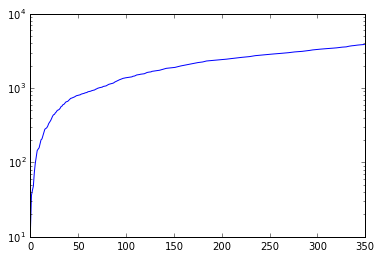

In [302]:
plt.plot((drug_profile_zip[1]).cumsum())
plt.yscale('log')

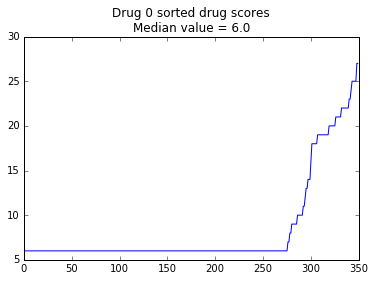

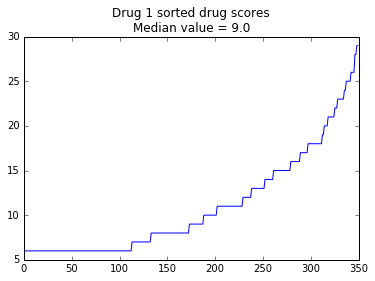

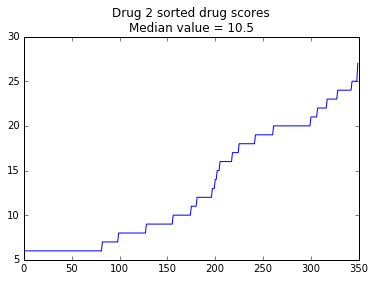

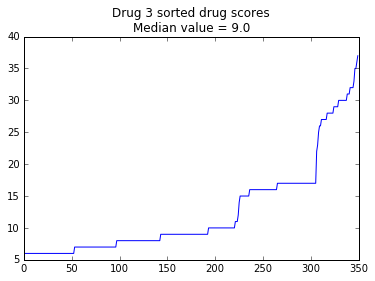

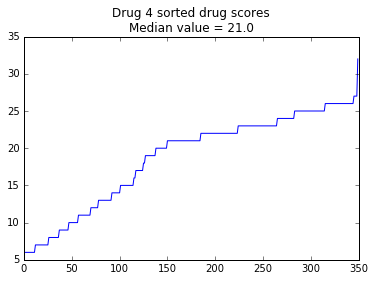

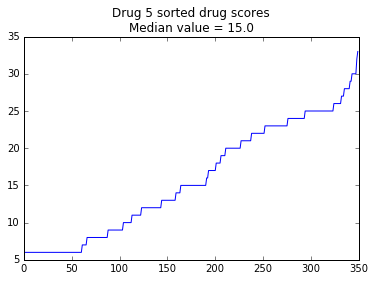

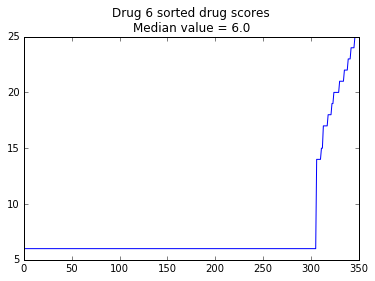

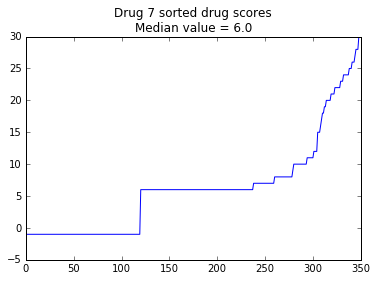

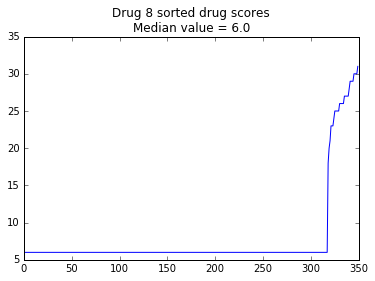

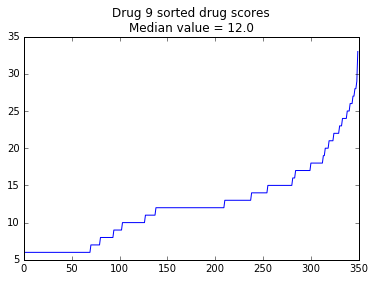

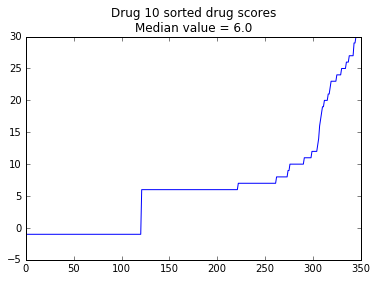

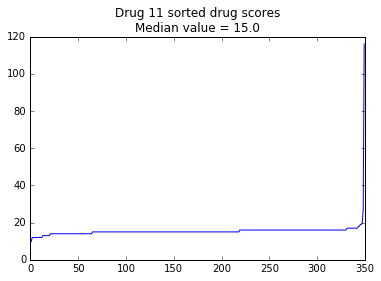

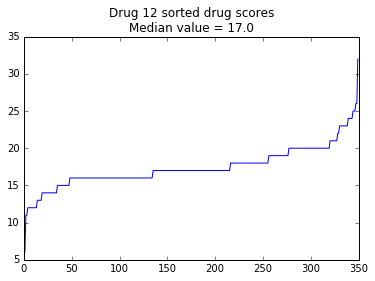

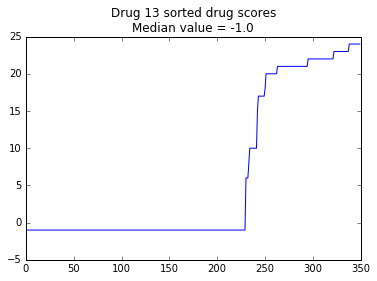

In [310]:
for i in range(14):
    plt.plot(sorted(drug_profile_zip[i]))
    plt.title('Drug '+ str(i) + ' sorted drug scores\nMedian value = ' + str(drug_profile_median_scores[i]))
    plt.savefig('Drug_'+ str(i) + '_sorted_drug_scores')
    plt.show()

In [17]:
drug_profile_median_scores = np.median(drug_profile_zip,axis=1)
drug_profile_median_scores

array([  6. ,   9. ,  10.5,   9. ,  21. ,  15. ,   6. ,   6. ,   6. ,
        12. ,   6. ,  15. ,  17. ,  -1. ,  -1. ])

In [83]:
np.median(drug_profile_zip[0])

6.0

In [18]:
drug_profile_binary_labels = np.array([[(lambda x: 1 if x>drug_profile_median_scores[i] else 0)(x) for x in drug_profile] for i, drug_profile in enumerate(drug_profile_zip)])

In [19]:
np.sum(drug_profile_binary_labels, axis=1)

array([ 74, 162, 175, 157, 165, 159,  44, 112,  32, 140, 128, 131, 134,
       120,   1])

In [93]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler

X = genes_pa_binary_features.T[467:].T
y = drug_profile_binary_labels[1]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
    
clf = LinearSVC(penalty='l1' , dual = False)
scores = cross_val_score(clf, X_test, y_test, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


[ 0.73333333  0.5         0.35714286  0.42857143  0.53846154]
Accuracy: 0.51 (+/- 0.25)


In [101]:
f = open('drug_profile_zip.npz','wb')
np.save(f, drug_profile_zip)
f.close()

In [21]:
[print(lines_gtable[i].split()[0], lines_gtable[i].split()[1:20]) for i in range(0, 10)]

Genome ['Cluster', 'NC_017162_547406', 'NC_017162_380765', 'NC_017162_3046244', 'NC_017162_583607', 'NC_017162_2559091', 'NC_017162_583601', 'NC_017162_547400', 'NC_017162_2386579', 'NC_017162_2142605', 'NC_017162_303112', 'NC_017162_3046248', 'NC_017162_651915', 'NC_017162_2561795', 'NC_017162_3056429', 'NC_017162_3798804', 'NC_017162_1275063', 'NC_017162_1978254', 'NC_017162_1059747']
JEWF01.1.fna ['14', 'T', 'C', 'G', 'C', 'NA', 'G', 'T', 'NA', 'G', 'NA', 'G', 'T', 'A', 'C', 'A', 'C', 'G', 'C']
JEWH01.1.fna ['19', 'T', 'A', 'A', 'NA', 'NA', 'NA', 'T', 'NA', 'G', 'G', 'G', 'G', 'NA', 'T', 'A', 'C', 'NA', 'T']
JEWJ01.1.fna ['11', 'T', 'C', 'G', 'NA', 'NA', 'NA', 'T', 'T', 'NA', 'NA', 'G', 'G', 'NA', 'C', 'A', 'C', 'NA', 'C']
JEWK01.1.fna ['12', 'T', 'C', 'G', 'C', 'NA', 'G', 'T', 'T', 'G', 'NA', 'G', 'NA', 'NA', 'C', 'A', 'NA', 'NA', 'NA']
JEWL01.1.fna ['19', 'T', 'A', 'A', 'NA', 'NA', 'NA', 'T', 'NA', 'A', 'G', 'G', 'G', 'NA', 'T', 'A', 'C', 'NA', 'T']
JEWM01.1.fna ['19', 'T', 'A', '

[None, None, None, None, None, None, None, None, None, None]

In [28]:
from collections import Counter
[Counter(lines_gtable[i].split()[2:-15]) for i in range(1,6)]

[Counter({'-': 21,
          'A': 45534,
          'C': 49641,
          'G': 49837,
          'K': 2,
          'M': 1,
          'NA': 70847,
          'R': 1,
          'T': 45201,
          'Y': 1}),
 Counter({'-': 101,
          'A': 38454,
          'B': 1,
          'C': 40327,
          'D': 1,
          'G': 40469,
          'K': 37,
          'M': 35,
          'NA': 102910,
          'R': 24,
          'S': 16,
          'T': 38624,
          'V': 1,
          'W': 70,
          'Y': 16}),
 Counter({'-': 17,
          'A': 41884,
          'C': 45587,
          'G': 45989,
          'NA': 85665,
          'T': 41944}),
 Counter({'-': 15,
          'A': 36160,
          'C': 39791,
          'G': 39670,
          'K': 1,
          'NA': 109166,
          'T': 36283}),
 Counter({'-': 96,
          'A': 38472,
          'B': 2,
          'C': 40038,
          'D': 2,
          'G': 40395,
          'H': 3,
          'K': 31,
          'M': 34,
          'NA': 102910,
          

In [20]:
snp_list = []
for line in lines_gtable[1:]:
    lsplit = line.split()
    temp = []
    for idx in range(2,len(lsplit)-15):
        if(lsplit[idx]=='A'):
            temp.append(1)
        elif(lsplit[idx]=='C'):
            temp.append(2)
        elif(lsplit[idx]=='G'):
            temp.append(3)
        elif(lsplit[idx]=='T'):
            temp.append(4)
        else:
            temp.append(0)
    snp_list.append(np.array(temp))
snp_list = np.array(snp_list)

In [33]:
snp_list.shape

(350, 261086)

In [36]:
f = open('snp_list.npz','wb')
np.save(f, snp_list)
f.close()

In [26]:
X_gene = genes_pa_binary_features.T[467:].T
X_snp = snp_list
X_combined = np.array(list(zip(*X_gene.T, *snp_list.T)))
#X = PCA().fit_transform(X)
X_combined = StandardScaler().fit_transform(X_combined)
X_gene = StandardScaler().fit_transform(X_gene)
X_snp = StandardScaler().fit_transform(X_snp)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [53]:
#f1 = open('Cross_validation_Binary_Labels_KFold_SGD_L1_SS_Gene.txt', 'w+')
#f2 = open('Cross_validation_Binary_Labels_KFold_SGD_L1_SS_SNP.txt', 'w+')
#f3 = open('Cross_validation_Binary_Labels_KFold_SGD_L1_SS_Gene-SNP.txt', 'w+')

X_gene = genes_pa_binary_features.T[467:].T
X_snp = snp_list
X_combined = np.array(list(zip(*X_gene.T, *snp_list.T)))
#X = PCA().fit_transform(X)
X_combined = StandardScaler().fit_transform(X_combined)
X_gene = StandardScaler().fit_transform(X_gene)
X_snp = StandardScaler().fit_transform(X_snp)
clf = SGDClassifier(penalty='l1')
#clf = LinearSVC(penalty='l1' , dual = False)
#clf = SVC(kernel='rbf')
#clf = AdaBoostClassifier()
#clf = RandomForestClassifier() #default no. of trees: n_estimators=10
#ignoring the last drug since it has data for only 1 sequence
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for i in range(len(drug_profile_zip)-1):
        y = drug_profile_binary_labels[i]
        
        #clf.fit(X_train, y_train)

        #y_true, y_pred = y_test, clf.predict(X_test)
        #print(classification_report(y_true, y_pred), file = f)
        #scores = cross_val_score(clf, X, y, cv=5)
        #print('Positive samples: train:',(1.0*np.sum(y_train))/len(y_train),'test:',(1.0*np.sum(y_test))/len(y_test), file=f)
        #print(scores, file = f)
        #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), file=f)
        #kf = KFold(n_splits=5)
        kf = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
#         for run in range(3):
#             if(run==0):
#                 X = X_gene
#                 f = f1
#             elif(run==1):
#                 X = X_snp
#                 f = f2
#             else:
#                 X = X_combined
#                 f = f3
        X = X_combined

        print('Drug',i,':')#,file=f)
        for train, test in kf.split(X):
                clf.fit(X[train], y[train])
                print('Train:', np.sum(y[train])/len(train))#, file=f)
                print('Test:', np.sum(y[test])/len(test))#, file=f)
                y_true, y_pred = y[test], clf.predict(X[test])
                print(classification_report(y_true, y_pred))#, file = f)
        print('\n\n')#,file=f)
# f1.close()
# f2.close()
# f3.close()

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Drug 0 :
Train: 0.210714285714
Test: 0.214285714286
             precision    recall  f1-score   support

          0       0.93      0.95      0.94        55
          1       0.79      0.73      0.76        15

avg / total       0.90      0.90      0.90        70

Train: 0.203571428571
Test: 0.242857142857
             precision    recall  f1-score   support

          0       0.94      0.96      0.95        53
          1       0.88      0.82      0.85        17

avg / total       0.93      0.93      0.93        70

Train: 0.214285714286
Test: 0.2
             precision    recall  f1-score   support

          0       0.92      0.84      0.88        56
          1       0.53      0.71      0.61        14

avg / total       0.84      0.81      0.82        70

Train: 0.225
Test: 0.157142857143
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        59
          1       1.00      0.73      0.84        11

avg / total       0.96      0.96 

In [54]:
y = drug_profile_binary_labels[1]
kf = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
X = X_combined
for train, test in kf.split(X):
        clf.fit(X[train], y[train])
        print('Train:', np.sum(y[train])/len(train))#, file=f)
        print('Test:', np.sum(y[test])/len(test))#, file=f)
        y_true, y_pred = y[test], clf.predict(X[test])
        print(classification_report(y_true, y_pred))#, file = f)
print('\n\n')#,file=f)

Train: 0.467857142857
Test: 0.442857142857
             precision    recall  f1-score   support

          0       0.80      0.85      0.83        39
          1       0.79      0.74      0.77        31

avg / total       0.80      0.80      0.80        70

Train: 0.460714285714
Test: 0.471428571429
             precision    recall  f1-score   support

          0       0.81      0.92      0.86        37
          1       0.89      0.76      0.82        33

avg / total       0.85      0.84      0.84        70

Train: 0.460714285714
Test: 0.471428571429
             precision    recall  f1-score   support

          0       0.61      0.46      0.52        37
          1       0.52      0.67      0.59        33

avg / total       0.57      0.56      0.55        70

Train: 0.442857142857
Test: 0.542857142857
             precision    recall  f1-score   support

          0       0.88      0.91      0.89        32
          1       0.92      0.89      0.91        38

avg / total       0.90

In [57]:
clf.coef_

array([[   4.99041314, -239.83443624, -240.87473683, ...,  -39.06029225,
         -15.80930902,   72.71548232]])

In [62]:
len(list(zip(*clf.coef_))), len(X[0])

(264979, 264979)

In [63]:
clf.coef_.shape

(1, 264979)

In [68]:
clf.coef_[0]

array([   4.99041314, -239.83443624, -240.87473683, ...,  -39.06029225,
        -15.80930902,   72.71548232])

In [100]:
np.mean(clf.coef_[0]), np.median(clf.coef_[0]), np.max(clf.coef_[0]), np.std(clf.coef_[0])

(1.1296807913351274, 0.0, 1115.7193402148005, 48.381217582460302)

In [71]:
np.sum(clf.coef_[0]>=np.median(clf.coef_[0]))

138711

In [82]:
np.sum(clf.coef_[0]==0)

7969

In [84]:
np.sum(np.abs(clf.coef_[0])<=10)

96011

In [85]:
np.sum(np.abs(clf.coef_[0])>500)

182

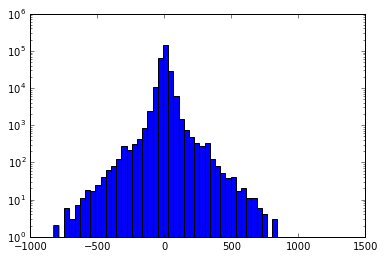

In [97]:
plt.hist(clf.coef_[0],bins=50)
plt.yscale('log')

In [77]:
np.sort(clf.coef_[0])[-30:]

array([  642.01898849,   643.2955714 ,   650.52296928,   652.92553971,
         653.10439508,   658.65360062,   661.46321145,   670.97896692,
         672.43406932,   674.75088314,   680.30568063,   681.29767013,
         688.05414886,   689.71172099,   690.74756278,   694.79812539,
         700.33293744,   711.05716583,   717.24252416,   727.79343345,
         732.86337743,   755.64350992,   764.54603866,   781.68985256,
         814.57875768,   818.51121552,   832.60635912,   870.66319368,
         908.34741322,  1115.71934021])

In [78]:
np.argsort(clf.coef_[0])[-30:]

array([127728, 251423, 165388,  12370, 171510,  78827, 103505, 198050,
        17902, 243490, 198042,  28720, 102772, 180799, 102773,   2482,
        54478, 228021,   3836,  90025, 107360, 141537, 195880, 131972,
        16427, 175566, 137212, 192119,  40537, 113755])

In [79]:
np.sort(clf.coef_[0])[:30]

array([-826.711948  , -802.75576749, -757.01160549, -733.03213551,
       -721.34623988, -718.48689448, -716.99424672, -713.3868603 ,
       -711.58027289, -704.91883873, -682.35097879, -680.70895724,
       -661.90070337, -656.71396219, -652.37987602, -650.08964889,
       -647.31121642, -644.72542216, -644.72542216, -631.14072469,
       -630.53193835, -629.83764558, -620.16088576, -613.19623255,
       -612.5759682 , -612.5759682 , -612.5759682 , -604.80435989,
       -602.97820558, -594.34978963])

In [80]:
np.argsort(clf.coef_[0])[:30]

array([ 16430,   6761,   3598, 127326, 152439, 149829, 203477,  27808,
       175799, 209981, 198594,  30641, 194979,   3804, 127337,   3673,
         3886,   3865,   3866, 222813,   2532,  48905, 231516,  18777,
         3745,   3747,   3742,   2771,  24552, 199313])

In [101]:
#clf = SGDClassifier(penalty='l1')
clf = LinearSVC(penalty='l1' , dual = False)
#clf = SVC(kernel='rbf')
#clf = AdaBoostClassifier()
#clf = RandomForestClassifier() #default no. of trees: n_estimators=10
#ignoring the last drug since it has data for only 1 sequence
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for i in range(len(drug_profile_zip)-1):
        y = drug_profile_binary_labels[i]
        kf = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
        X = X_combined

        print('Drug',i,':')#,file=f)
        for train, test in kf.split(X):
                clf.fit(X[train], y[train])
                print('Train:', np.sum(y[train])/len(train))#, file=f)
                print('Test:', np.sum(y[test])/len(test))#, file=f)
                y_true, y_pred = y[test], clf.predict(X[test])
                print(classification_report(y_true, y_pred))#, file = f)
        print('\n\n')#,file=f)

Drug 0 :
Train: 0.210714285714
Test: 0.214285714286
             precision    recall  f1-score   support

          0       1.00      0.96      0.98        55
          1       0.88      1.00      0.94        15

avg / total       0.97      0.97      0.97        70

Train: 0.203571428571
Test: 0.242857142857
             precision    recall  f1-score   support

          0       0.96      0.98      0.97        53
          1       0.94      0.88      0.91        17

avg / total       0.96      0.96      0.96        70

Train: 0.214285714286
Test: 0.2
             precision    recall  f1-score   support

          0       0.96      0.96      0.96        56
          1       0.86      0.86      0.86        14

avg / total       0.94      0.94      0.94        70

Train: 0.225
Test: 0.157142857143
             precision    recall  f1-score   support

          0       0.97      0.97      0.97        59
          1       0.82      0.82      0.82        11

avg / total       0.94      0.94 

In [112]:
y = drug_profile_binary_labels[1]
kf = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
X = X_combined
for train, test in kf.split(X):
        clf.fit(X[train], y[train])
        print('Train:', np.sum(y[train])/len(train))#, file=f)
        print('Test:', np.sum(y[test])/len(test))#, file=f)
        y_true, y_pred = y[test], clf.predict(X[test])
        print(classification_report(y_true, y_pred))#, file = f)
print('\n\n')#,file=f)

Train: 0.467857142857
Test: 0.442857142857
             precision    recall  f1-score   support

          0       0.83      0.87      0.85        39
          1       0.83      0.77      0.80        31

avg / total       0.83      0.83      0.83        70

Train: 0.460714285714
Test: 0.471428571429
             precision    recall  f1-score   support

          0       0.85      0.95      0.90        37
          1       0.93      0.82      0.87        33

avg / total       0.89      0.89      0.88        70

Train: 0.460714285714
Test: 0.471428571429
             precision    recall  f1-score   support

          0       0.85      0.89      0.87        37
          1       0.87      0.82      0.84        33

avg / total       0.86      0.86      0.86        70

Train: 0.442857142857
Test: 0.542857142857
             precision    recall  f1-score   support

          0       0.88      0.94      0.91        32
          1       0.94      0.89      0.92        38

avg / total       0.92

In [114]:
np.mean(clf.coef_[0]), np.median(clf.coef_[0]), np.std(clf.coef_[0])

(-3.1043120873164207e-07, 0.0, 0.0016731644200839041)

In [115]:
np.sum(clf.coef_[0]==0), len(clf.coef_[0])

(264813, 264979)

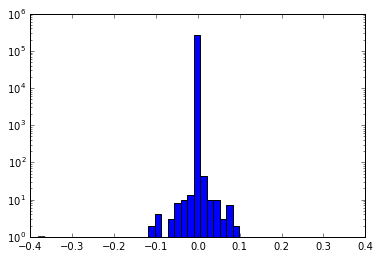

In [117]:
plt.hist(clf.coef_[0],bins=50)
plt.yscale('log')

In [118]:
np.max(clf.coef_[0]), np.min(clf.coef_[0])

(0.39238438854955476, -0.38119400203696796)

In [119]:
np.sum(clf.coef_[0] >= np.mean(clf.coef_[0]) + 3*np.std(clf.coef_[0]))

78

In [120]:
np.sum(clf.coef_[0] <= np.mean(clf.coef_[0]) - 3*np.std(clf.coef_[0]))

51

In [121]:
np.argwhere(clf.coef_[0] >= np.mean(clf.coef_[0]) + 3*np.std(clf.coef_[0]))

array([[    60],
       [    90],
       [    94],
       [   113],
       [   166],
       [   220],
       [   247],
       [   290],
       [   326],
       [   329],
       [   413],
       [   470],
       [   474],
       [   513],
       [   619],
       [   628],
       [   673],
       [   858],
       [   879],
       [   897],
       [  1076],
       [  1228],
       [  1243],
       [  1251],
       [  1326],
       [  1353],
       [  1535],
       [  1636],
       [  1699],
       [  1817],
       [  1881],
       [  2227],
       [  2340],
       [  2345],
       [  2562],
       [  3375],
       [  3387],
       [  3513],
       [  7821],
       [ 31103],
       [ 33590],
       [ 35797],
       [ 57558],
       [ 72084],
       [ 74442],
       [ 78841],
       [ 94995],
       [ 95017],
       [ 96251],
       [ 97406],
       [104983],
       [113755],
       [119059],
       [123026],
       [130410],
       [134343],
       [140580],
       [141635],
       [152360

In [122]:
np.argsort(clf.coef_[0])[-78:]

array([    60,    247,    858,     90,    113,    326,   2345,  31103,
         1251,   1699,    470,   2340,    220,     94, 104983,    290,
        33590,  74442,    673,   3375,    879, 257612,  94995,  95017,
       134343,   2227,  72084,  96251,    413,   1535, 152360,   1817,
        97406, 168691,   1326, 174496, 218990, 236517, 224730,   3387,
        57558, 177536,   1353,    513, 141635,    474, 170898, 251544,
        78841,   7821, 140580,    619,    329, 254621, 215473, 199186,
       246063,    628, 164499,   3513,   1881,   2562, 251323,    897,
       228021,    166,   1076,   1636, 228712,   1243,  35797, 123026,
       119059, 130410,   1228, 165388, 243943, 113755])

In [133]:
clf.coef_[0] + np.ones(len(clf.coef_[0]))

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [129]:
combined_coef = np.load('../LinearSVC_coef_drug1.npz')

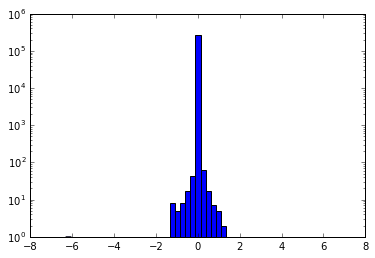

In [132]:
plt.hist(combined_coef, bins=50)
plt.yscale('log')

In [136]:
np.mean(combined_coef), np.median(combined_coef), np.std(combined_coef)

(2.1791589840226228e-05, 0.0, 0.024695670392112373)

In [137]:
np.sum(combined_coef >= np.mean(combined_coef) + 3*np.std(combined_coef))

137

In [138]:
np.sum(combined_coef <= np.mean(combined_coef) - 3*np.std(combined_coef))

108

In [139]:
ave_combined_coef = combined_coef/20

In [140]:
np.mean(ave_combined_coef), np.median(ave_combined_coef), np.std(ave_combined_coef)

(1.089579492011312e-06, 0.0, 0.0012347835196056189)

In [142]:
np.sum(ave_combined_coef >= np.mean(ave_combined_coef) + 3*np.std(ave_combined_coef))

137

In [143]:
np.argwhere(combined_coef >= np.mean(combined_coef) + 3*np.std(combined_coef))

array([[     8],
       [    34],
       [    93],
       [    94],
       [   137],
       [   165],
       [   166],
       [   186],
       [   196],
       [   220],
       [   232],
       [   237],
       [   247],
       [   276],
       [   290],
       [   320],
       [   326],
       [   329],
       [   399],
       [   459],
       [   474],
       [   513],
       [   619],
       [   628],
       [   701],
       [   787],
       [   876],
       [   883],
       [   897],
       [   968],
       [  1048],
       [  1076],
       [  1228],
       [  1237],
       [  1243],
       [  1317],
       [  1326],
       [  1535],
       [  1573],
       [  1634],
       [  1636],
       [  1817],
       [  1881],
       [  2562],
       [  3029],
       [  3122],
       [  3819],
       [  3835],
       [  7605],
       [  7821],
       [  9187],
       [ 11808],
       [ 14439],
       [ 17902],
       [ 20323],
       [ 22190],
       [ 32809],
       [ 33590],
       [ 35042

In [144]:
np.argsort(combined_coef)[-137:]

array([166558, 128948,  67768,   1317, 259379,  44093,   3122, 237898,
        55465,    968,  49240, 202770,    232, 167807,  84540, 100633,
       262828,  92158, 104983,  32809, 168385,   3029,  95017,    276,
       211276,    196,  35797,    326,    137, 166434,    165, 118977,
       201026,   1881,    237, 257612,    787, 120645,  33590,   3819,
       152800,  57558,  83745, 179797,    459,  17902,   1636,  14439,
       251323,  35042,   3835, 224730,  74442,  22190,  78841, 177536,
         1535,  54637,    876, 173043, 112380, 172404,  49124, 168691,
       220240, 143512,   2562,    186, 237212,  76753, 141635, 199186,
          220,   1326, 152360,  20323, 190757,  86558,    320,     93,
           34,     94, 120911,   1817, 215473, 262553,    290,   1048,
         1237, 235591, 185835,      8,  54478,    247,    166,  97406,
          619,  48049,   1573, 174918,    628,  75769,    399,    513,
         7605,   1634, 170898, 246063,  96251,  94995,  11808,  40537,
      

In [147]:
len(X_gene[0]), len(X_gene[0])+467, len(X_snp[0])

(3893, 4360, 261086)

In [15]:
carbapenem_combined_coef = []
[carbapenem_combined_coef.append(np.load('../carbapenems/LinearSVC_coef_drug'+str(i)+'.npz')) for i in range(3)]
carbapenem_combined_coef = np.array(carbapenem_combined_coef)

Drug 0
mean: 1.3473620161e-05 median: 0.0 std: 0.0186854844102 min: -2.48646639533 max: 4.00224566201
Positive features: 241
Negative features: 267


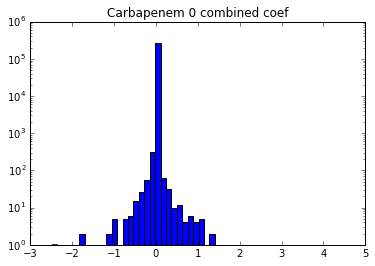

Drug 1
mean: -2.46661027018e-05 median: 0.0 std: 0.0178027069199 min: -3.32699321974 max: 2.2324174672
Positive features: 203
Negative features: 191


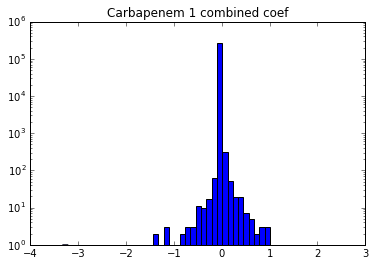

Drug 2
mean: -5.03033641551e-05 median: 0.0 std: 0.0170279914578 min: -2.58688460042 max: 1.53449832128
Positive features: 219
Negative features: 215


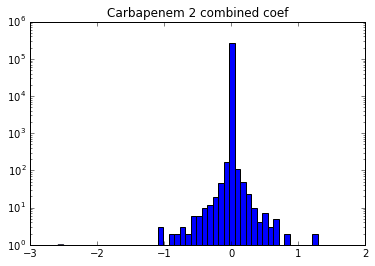

In [16]:
for i in range(3):
    print('Drug', i)
    print('mean:', np.mean(carbapenem_combined_coef[i]), 'median:', np.median(carbapenem_combined_coef[i]),
          'std:', np.std(carbapenem_combined_coef[i]), 'min:', np.min(carbapenem_combined_coef[i]),
          'max:', np.max(carbapenem_combined_coef[i]))
    print('Positive features:', np.sum(carbapenem_combined_coef[i] >= np.mean(carbapenem_combined_coef[i]) + 3*np.std(carbapenem_combined_coef[i])))
    print('Negative features:', np.sum(carbapenem_combined_coef[i] <= np.mean(carbapenem_combined_coef[i]) - 3*np.std(carbapenem_combined_coef[i])))
    plt.hist(carbapenem_combined_coef[i], bins=50)
    plt.yscale('log')
    plt.title('Carbapenem '+str(i)+' combined coef')
    plt.show()

In [17]:
carbapenem_positively_correlated = []
carbapenem_negatively_correlated = []
for i in range(3):
    mean = np.mean(carbapenem_combined_coef[i])
    std = np.std(carbapenem_combined_coef[i])
    argsort = np.argsort(carbapenem_combined_coef[i])
    count = np.sum(carbapenem_combined_coef[i] >= mean + 3*std)
    carbapenem_positively_correlated.append(argsort[-count:])
    count = np.sum(carbapenem_combined_coef[i] <= mean - 3*std)
    carbapenem_negatively_correlated.append(argsort[:count])
    print('Drug', i, mean, std, len(carbapenem_positively_correlated[i]), len(carbapenem_negatively_correlated[i]))
carbapenem_positively_correlated = np.array(carbapenem_positively_correlated)
carbapenem_negatively_correlated = np.array(carbapenem_negatively_correlated)

Drug 0 1.3473620161e-05 0.0186854844102 241 267
Drug 1 -2.46661027018e-05 0.0178027069199 203 191
Drug 2 -5.03033641551e-05 0.0170279914578 219 215


In [22]:
snp_list = np.array(snp_list)

In [25]:
carbapenem_drug_idx = np.array([3, 7, 10])
carbapenem_susceptibility_threshold = np.array([2, 2, 2])
carbapenem_resistance_threshold = np.array([8, 8, 8])
carbapenem_drug_profile_zip = drug_profile_zip[carbapenem_drug_idx]
carbapenem_drug_sequences_bool = np.array([drug_profile!=-1 for drug_profile in carbapenem_drug_profile_zip])

X = []
X_gene = []
X_snp = []

for i in range(drug_count):
	X_gene = genes_pa_binary_features[carbapenem_drug_sequences_bool[i]]
	X_snp = snp_list[carbapenem_drug_sequences_bool[i]]
	X_combined = np.array(list(zip(*X_gene.T, *snp_list.T)))

	X_combined = StandardScaler().fit_transform(X_combined)
	# X_gene = StandardScaler().fit_transform(X_gene)
	# X_snp = StandardScaler().fit_transform(X_snp)

	X.append(X_combined)

	#y = carbapenem_drug_profile_binary_labels[i]
X = np.array(X)


#Find the important features (genes/SNPs) observed across all the 4x5Fold cross validation runs

carbapenem_combined_coef = []
[carbapenem_combined_coef.append(np.load('../carbapenems/LinearSVC_coef_drug'+str(i)+'.npz')) for i in range(3)]
carbapenem_combined_coef = np.array(carbapenem_combined_coef)

carbapenem_positively_correlated = []
carbapenem_negatively_correlated = []
for i in range(3):
    mean = np.mean(carbapenem_combined_coef[i])
    std = np.std(carbapenem_combined_coef[i])
    argsort = np.argsort(carbapenem_combined_coef[i])
    count = np.sum(carbapenem_combined_coef[i] >= mean + 3*std)
    carbapenem_positively_correlated.append(argsort[-count:])
    count = np.sum(carbapenem_combined_coef[i] <= mean - 3*std)
    carbapenem_negatively_correlated.append(argsort[:count])
    print('Drug', i, mean, std, len(carbapenem_positively_correlated[i]), len(carbapenem_negatively_correlated[i]))
carbapenem_positively_correlated = np.array(carbapenem_positively_correlated)
carbapenem_negatively_correlated = np.array(carbapenem_negatively_correlated)

Gene = genes_pa_small_zip[0][1:]
SNP = np.array(lines_gtable[0].split()[2:-15])

carbapenem_gene_positively_correlated_idx = []
carbapenem_gene_negatively_correlated_idx = []
carbapenem_snp_positively_correlated_idx = []
carbapenem_snp_negatively_correlated_idx = []

print('Drug\tGene positive\tGene negative\tSNP positive\tSNP negative')
for i in range(drug_count):
    carbapenem_gene_positive_idx = carbapenem_positively_correlated[i][carbapenem_positively_correlated[i]<len(X_gene[i])]
    #gene_positive_idx = gene_positive_idx + 467*np.ones(len(gene_positive_idx))
    carbapenem_gene_positive_idx = carbapenem_gene_positive_idx.astype(int)
    
    carbapenem_gene_negative_idx = carbapenem_negatively_correlated[i][carbapenem_negatively_correlated[i]<len(X_gene[i])]
    #gene_negative_idx = gene_negative_idx + 467*np.ones(len(gene_negative_idx))
    carbapenem_gene_negative_idx = carbapenem_gene_negative_idx.astype(int)
    
    carbapenem_snp_positive_idx = carbapenem_positively_correlated[i][carbapenem_positively_correlated[i]>=len(X_gene[i])]
    carbapenem_snp_positive_idx = carbapenem_snp_positive_idx - len(X_gene[i])*np.ones(len(carbapenem_snp_positive_idx))
    carbapenem_snp_positive_idx = carbapenem_snp_positive_idx.astype(int)
    
    carbapenem_snp_negative_idx = carbapenem_negatively_correlated[i][carbapenem_negatively_correlated[i]>=len(X_gene[i])]
    carbapenem_snp_negative_idx = carbapenem_snp_negative_idx - len(X_gene[i])*np.ones(len(carbapenem_snp_negative_idx))
    carbapenem_snp_negative_idx = carbapenem_snp_negative_idx.astype(int)
    
    carbapenem_gene_positively_correlated_idx.append(carbapenem_gene_positive_idx)
    carbapenem_gene_negatively_correlated_idx.append(carbapenem_gene_negative_idx)
    carbapenem_snp_positively_correlated_idx.append(carbapenem_snp_positive_idx)
    carbapenem_snp_negatively_correlated_idx.append(carbapenem_snp_negative_idx)
    
    print(i, '\t\t', len(carbapenem_gene_positively_correlated_idx[i]), '\t\t', len(carbapenem_gene_negatively_correlated_idx[i]),
         '\t\t', len(carbapenem_snp_positively_correlated_idx[i]), '\t\t', len(carbapenem_snp_negatively_correlated_idx[i]))

carbapenem_gene_positively_correlated_idx = np.array(carbapenem_gene_positively_correlated_idx)
carbapenem_gene_negatively_correlated_idx = np.array(carbapenem_gene_negatively_correlated_idx)
carbapenem_snp_positively_correlated_idx = np.array(carbapenem_snp_positively_correlated_idx)
carbapenem_snp_negatively_correlated_idx = np.array(carbapenem_snp_negatively_correlated_idx)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Drug 0 1.3473620161e-05 0.0186854844102 241 267
Drug 1 -2.46661027018e-05 0.0178027069199 203 191
Drug 2 -5.03033641551e-05 0.0170279914578 219 215
Drug	Gene positive	Gene negative	SNP positive	SNP negative
0 		 132 		 148 		 109 		 119
1 		 141 		 132 		 62 		 59
2 		 160 		 130 		 59 		 85


In [21]:
drug_combined_coef = []
[drug_combined_coef.append(np.load('../LinearSVC_coef_drug'+str(i)+'.npz')) for i in range(14)]
drug_combined_coef = np.array(drug_combined_coef)

Drug 0
mean: -1.84315160244e-05 median: 0.0 std: 0.0136874777581 min: -4.32227008156 max: 1.76497974829
Positive features: 111
Negative features: 125


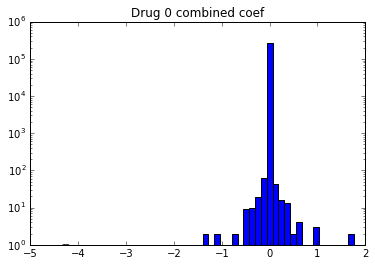

Drug 1
mean: 2.17915898402e-05 median: 0.0 std: 0.0246956703921 min: -6.30662825477 max: 6.06809796778
Positive features: 137
Negative features: 108


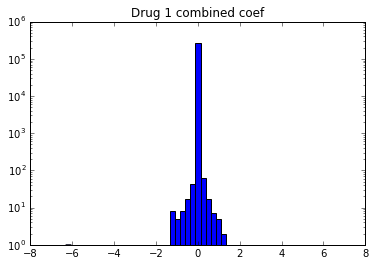

Drug 2
mean: -3.76473401802e-06 median: 0.0 std: 0.0266265471475 min: -2.97414889136 max: 9.25337843597
Positive features: 139
Negative features: 139


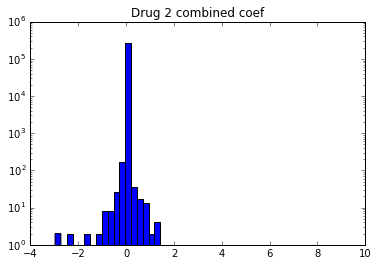

Drug 3
mean: -5.114684238e-05 median: 0.0 std: 0.0255450166336 min: -7.65386079982 max: 5.14966260704
Positive features: 168
Negative features: 210


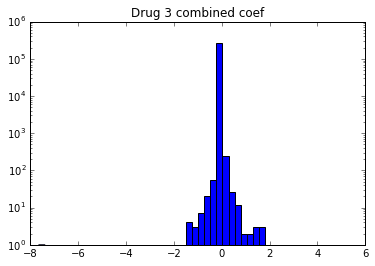

Drug 4
mean: -5.01549563359e-05 median: 0.0 std: 0.0224756718166 min: -4.39199185497 max: 5.6627619071
Positive features: 202
Negative features: 240


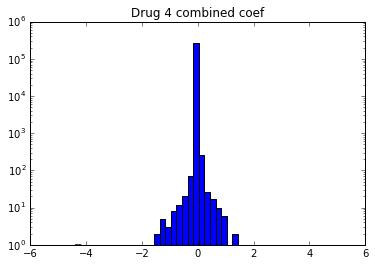

Drug 5
mean: 8.91352811587e-06 median: 0.0 std: 0.0205522804198 min: -2.92163374184 max: 4.05900839765
Positive features: 80
Negative features: 89


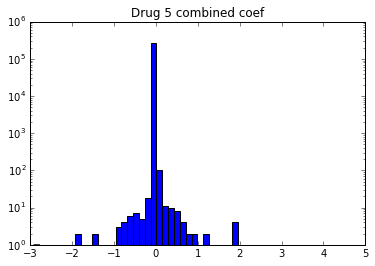

Drug 6
mean: -7.29097332222e-05 median: 0.0 std: 0.0136253624624 min: -4.49137233563 max: 1.67024124327
Positive features: 47
Negative features: 110


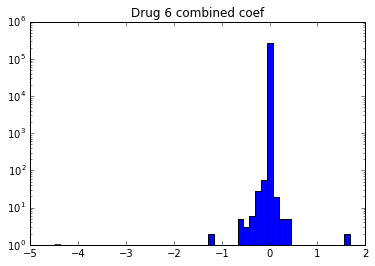

Drug 7
mean: -5.85994706463e-05 median: 0.0 std: 0.023201058034 min: -4.07280006767 max: 6.88291645868
Positive features: 174
Negative features: 231


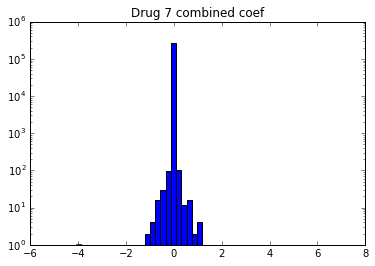

Drug 8
mean: -2.98548218539e-05 median: 0.0 std: 0.0118022855768 min: -3.32884531184 max: 4.38430259136
Positive features: 15
Negative features: 70


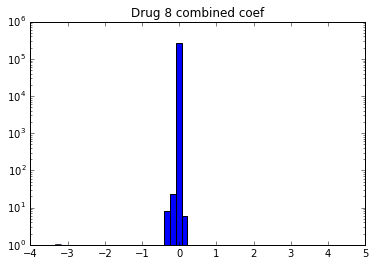

Drug 9
mean: 6.33499817235e-05 median: 0.0 std: 0.0215339291331 min: -2.63925779493 max: 6.02785120884
Positive features: 159
Negative features: 159


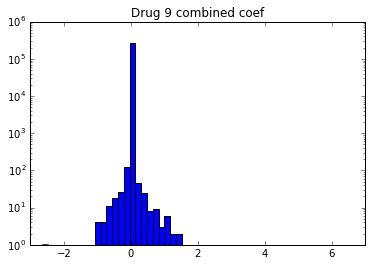

Drug 10
mean: -1.58363973307e-05 median: 0.0 std: 0.020615787665 min: -3.17724324395 max: 4.02588220573
Positive features: 241
Negative features: 257


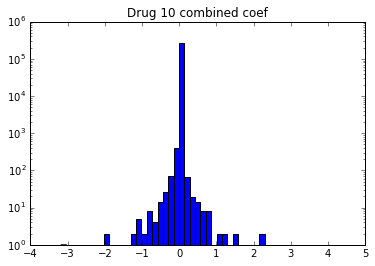

Drug 11
mean: -4.51442100031e-05 median: 0.0 std: 0.020013075422 min: -2.2089641723 max: 2.82040034212
Positive features: 313
Negative features: 352


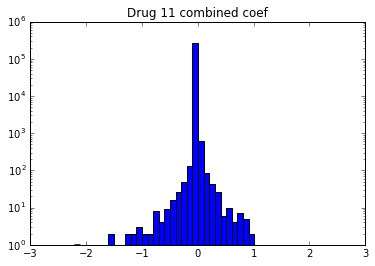

Drug 12
mean: -4.91363817431e-05 median: 0.0 std: 0.0196914969988 min: -3.34492297374 max: 4.38809279291
Positive features: 229
Negative features: 314


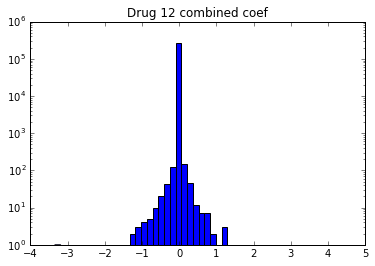

Drug 13
mean: 1.12080098256e-05 median: 0.0 std: 0.0234589535292 min: -4.29302010904 max: 5.73547764688
Positive features: 188
Negative features: 185


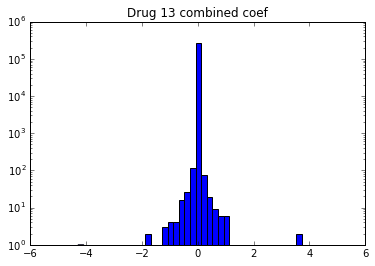

In [25]:
for i in range(len(drug_profile_zip)-1):
    print('Drug', i)
    print('mean:', np.mean(drug_combined_coef[i]), 'median:', np.median(drug_combined_coef[i]),
          'std:', np.std(drug_combined_coef[i]), 'min:', np.min(drug_combined_coef[i]),
          'max:', np.max(drug_combined_coef[i]))
    print('Positive features:', np.sum(drug_combined_coef[i] >= np.mean(drug_combined_coef[i]) + 3*np.std(drug_combined_coef[i])))
    print('Negative features:', np.sum(drug_combined_coef[i] <= np.mean(drug_combined_coef[i]) - 3*np.std(drug_combined_coef[i])))
    plt.hist(drug_combined_coef[i], bins=50)
    plt.yscale('log')
    plt.title('Drug '+str(i)+' combined coef')
    plt.show()

In [22]:
positively_correlated = []
negatively_correlated = []
for i in range(len(drug_profile_zip)-1):
    mean = np.mean(drug_combined_coef[i])
    std = np.std(drug_combined_coef[i])
    argsort = np.argsort(drug_combined_coef[i])
    count = np.sum(drug_combined_coef[i] >= mean + 3*std)
    positively_correlated.append(argsort[-count:])
    count = np.sum(drug_combined_coef[i] <= mean - 3*std)
    negatively_correlated.append(argsort[:count])
    print('Drug', i, mean, std, len(positively_correlated[i]), len(negatively_correlated[i]))
positively_correlated = np.array(positively_correlated)
negatively_correlated = np.array(negatively_correlated)

Drug 0 -1.84315160244e-05 0.0136874777581 111 125
Drug 1 2.17915898402e-05 0.0246956703921 137 108
Drug 2 -3.76473401802e-06 0.0266265471475 139 139
Drug 3 -5.114684238e-05 0.0255450166336 168 210
Drug 4 -5.01549563359e-05 0.0224756718166 202 240
Drug 5 8.91352811587e-06 0.0205522804198 80 89
Drug 6 -7.29097332222e-05 0.0136253624624 47 110
Drug 7 -5.85994706463e-05 0.023201058034 174 231
Drug 8 -2.98548218539e-05 0.0118022855768 15 70
Drug 9 6.33499817235e-05 0.0215339291331 159 159
Drug 10 -1.58363973307e-05 0.020615787665 241 257
Drug 11 -4.51442100031e-05 0.020013075422 313 352
Drug 12 -4.91363817431e-05 0.0196914969988 229 314
Drug 13 1.12080098256e-05 0.0234589535292 188 185


In [123]:
(gene_positively_correlated_idx[2] - 467*np.ones(len(gene_positively_correlated_idx[2]))).astype(int)

array([1978,  166,  186, 3688, 1368, 1578, 3510,  788, 1388, 1196, 1625,
        329, 1493,   34, 1048, 3197, 1222, 3427, 2011, 3272,  290, 2046,
       1348,  722,  220,  191,   93, 1321, 3820, 3286,    9, 3084, 1144,
       3428,  198,  800, 3540,  628, 2899, 1746, 1805, 1228, 1006, 1025,
        896, 1146, 3237,  787,  330,  736, 1526,  754, 1531, 1400,  731,
       3825, 2216, 3122,  737, 1302, 2055, 1251,  126,  979, 1867, 1349])

In [121]:
drug_combined_coef[2][(gene_positively_correlated_idx[2] - 467*np.ones(len(gene_positively_correlated_idx[2]))).astype(int)]

array([ 0.0803103 ,  0.08073301,  0.08171824,  0.08367611,  0.08372931,
        0.08412422,  0.0873943 ,  0.09309724,  0.09360133,  0.09421647,
        0.09686692,  0.09723068,  0.0981037 ,  0.09849063,  0.10175526,
        0.10256565,  0.10332521,  0.1099087 ,  0.11179684,  0.11301175,
        0.11379712,  0.11440574,  0.1169598 ,  0.11881029,  0.11886498,
        0.12116721,  0.1217983 ,  0.12556515,  0.12967816,  0.13099783,
        0.14003447,  0.14530542,  0.15294121,  0.16956169,  0.16956201,
        0.1786976 ,  0.1800444 ,  0.18503536,  0.18697572,  0.18781883,
        0.19644348,  0.19994422,  0.20460826,  0.20510491,  0.22375739,
        0.22983007,  0.25753357,  0.26273985,  0.27006929,  0.28234273,
        0.29183179,  0.30339648,  0.30362696,  0.32370743,  0.3395096 ,
        0.44123254,  0.50805013,  0.538582  ,  0.55572211,  0.58886321,
        0.62066428,  0.63038904,  0.67884951,  0.7209822 ,  0.85476033,
        1.03079914])

In [23]:
SNP = np.array(lines_gtable[0].split()[2:-15])
print(len(SNP), SNP[:5])

261086 ['NC_017162_547406' 'NC_017162_380765' 'NC_017162_3046244'
 'NC_017162_583607' 'NC_017162_2559091']


In [24]:
Gene = genes_pa_small_zip[0][1:]
print(len(Gene), Gene[:5])

4360 ['mepA' 'yciC' 'group_10125' 'folC' 'group_10229']


In [30]:
from sklearn.preprocessing import StandardScaler

X_gene = genes_pa_binary_features.T[467:].T
X_snp = snp_list
X_combined = np.array(list(zip(*X_gene.T, *snp_list.T)))
#X = PCA().fit_transform(X)
X_combined = StandardScaler().fit_transform(X_combined)
X_gene = StandardScaler().fit_transform(X_gene)
X_snp = StandardScaler().fit_transform(X_snp)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [ ]:
snp_positive_idx = positively_correlated[1][positively_correlated[1]>=len(X_gene[0])]
snp_positive_idx = snp_positive_idx - len(X_gene[0])*np.ones(len(snp_positive_idx))
snp_positive_idx

In [180]:
SNP[snp_positive_idx.astype(int)]

array(['NC_017162_3125777', 'NC_017162_3423236', 'NC_017162_1717948',
       'NC_017162_3316107', 'NC_017162_71609', 'NC_017162_2215861',
       'NC_017162_1739994', 'NC_017162_1299783', 'NC_017162_654349',
       'NC_017162_2063836', 'NC_017162_2721383', 'NC_017162_903278',
       'NC_017162_71927', 'NC_017162_2070769', 'NC_017162_1989523',
       'NC_017162_3718991', 'NC_017162_2271390', 'NC_017162_3378446',
       'NC_017162_1305525', 'NC_017162_1747370', 'NC_017162_2979470',
       'NC_017162_2215178', 'NC_017162_2835998', 'NC_017162_3771677',
       'NC_017162_2070483', 'NC_017162_645784', 'NC_017162_42371',
       'NC_017162_747947', 'NC_017162_2879967', 'NC_017162_563680',
       'NC_017162_3320064', 'NC_017162_3320468', 'NC_017162_1313837',
       'NC_017162_3521059', 'NC_017162_356813', 'NC_017162_3146547',
       'NC_017162_3893378', 'NC_017162_2973430', 'NC_017162_518009',
       'NC_017162_42425', 'NC_017162_121021', 'NC_017162_119126',
       'NC_017162_3720642', 'NC_01716

In [32]:
gene_positive_idx = positively_correlated[1][positively_correlated[1]<len(X_gene[0])]
gene_positive_idx = gene_positive_idx + 467*np.ones(len(gene_positive_idx))
gene_positive_idx

array([ 1784.,  3589.,  1435.,   699.,  3496.,   743.,   663.,   793.,
         604.,   632.,  2348.,   704.,  1254.,  4286.,   926.,  2103.,
        4302.,  2002.,  1343.,  3029.,   653.,   687.,  1793.,   787.,
         560.,   501.,   561.,  2284.,   757.,  1515.,  1704.,   475.,
         714.,   633.,  1086.,  2040.,  1095.,   866.,   980.,  2101.,
         941.,  1543.,  1710.,  1168.,  1350.,   796.,  1364.,  1695.])

In [191]:
Gene[gene_positive_idx.astype(int)]

array(['group_11540', 'group_31352', 'group_32991', 'group_32421', 'ygcS',
       'racX', 'cysA_1', 'group_14636', 'group_28814', 'metI_2',
       'group_160', 'ybeY', 'group_14698', 'group_28520', 'ndvA',
       'group_3560', 'group_31892', 'fghA', 'group_15400', 'gdhB_1',
       'group_30978', 'group_32220', 'antC', 'oppA_2', 'xpt', 'miaB',
       'group_17405', 'group_964', 'group_7631', 'guaA_3', 'group_17374',
       'group_11456', 'crt_3', 'group_30389', 'group_7552', 'ndmA',
       'group_9946', 'etfA', 'apaH', 'metN_2', 'apbC', 'group_29125',
       'group_31182', 'rlmH', 'hpt', 'group_14708', 'group_32051', 'mtnN_1'], 
      dtype='<U519')

In [27]:
Gene = genes_pa_small_zip[0][1:]
SNP = np.array(lines_gtable[0].split()[2:-15])

gene_positively_correlated_idx = []
gene_negatively_correlated_idx = []
snp_positively_correlated_idx = []
snp_negatively_correlated_idx = []

print('Drug\tGene positive\tGene negative\tSNP positive\tSNP negative')
for i in range(len(drug_profile_zip)-1):
    gene_positive_idx = positively_correlated[i][positively_correlated[i]<len(X_gene[i])]
    gene_positive_idx = gene_positive_idx + 467*np.ones(len(gene_positive_idx))
    gene_positive_idx = gene_positive_idx.astype(int)
    
    gene_negative_idx = negatively_correlated[i][negatively_correlated[i]<len(X_gene[i])]
    gene_negative_idx = gene_negative_idx + 467*np.ones(len(gene_negative_idx))
    gene_negative_idx = gene_negative_idx.astype(int)
    
    snp_positive_idx = positively_correlated[i][positively_correlated[i]>=len(X_gene[i])]
    snp_positive_idx = snp_positive_idx - len(X_gene[i])*np.ones(len(snp_positive_idx))
    snp_positive_idx = snp_positive_idx.astype(int)
    
    snp_negative_idx = negatively_correlated[i][negatively_correlated[i]>=len(X_gene[i])]
    snp_negative_idx = snp_negative_idx - len(X_gene[i])*np.ones(len(snp_negative_idx))
    snp_negative_idx = snp_negative_idx.astype(int)
    
    gene_positively_correlated_idx.append(gene_positive_idx)
    gene_negatively_correlated_idx.append(gene_negative_idx)
    snp_positively_correlated_idx.append(snp_positive_idx)
    snp_negatively_correlated_idx.append(snp_negative_idx)
    
    print(i, '\t\t', len(gene_positively_correlated_idx[i]), '\t\t', len(gene_negatively_correlated_idx[i]),
         '\t\t', len(snp_positively_correlated_idx[i]), '\t\t', len(snp_negatively_correlated_idx[i]))

gene_positively_correlated_idx = np.array(gene_positively_correlated_idx)
gene_negatively_correlated_idx = np.array(gene_negatively_correlated_idx)
snp_positively_correlated_idx = np.array(snp_positively_correlated_idx)
snp_negatively_correlated_idx = np.array(snp_negatively_correlated_idx)

Drug	Gene positive	Gene negative	SNP positive	SNP negative
0 		 36 		 44 		 75 		 81
1 		 48 		 36 		 89 		 72
2 		 66 		 82 		 73 		 57
3 		 92 		 123 		 76 		 87
4 		 110 		 138 		 92 		 102
5 		 37 		 21 		 43 		 68
6 		 11 		 36 		 36 		 74
7 		 91 		 141 		 83 		 90
8 		 1 		 13 		 14 		 57
9 		 80 		 81 		 79 		 78
10 		 146 		 152 		 95 		 105
11 		 186 		 212 		 127 		 140
12 		 124 		 181 		 105 		 133
13 		 105 		 110 		 83 		 75


In [28]:
sequences[drug_profile_binary_labels[1]==1]

array(['JEWF01', 'JEWH01', 'JEWL01', 'JEWM01', 'JEWO01', 'JEWQ01',
       'JEWY01', 'JEWZ01', 'JEXB01', 'JEXC01', 'JEXD01', 'JEXI01',
       'JEXJ01', 'JEXK01', 'JEXL01', 'JEXM01', 'JEXN01', 'JEXP01',
       'JEXR01', 'JEXT01', 'JEXU01', 'JEXY01', 'JEYC01', 'JEYE01',
       'JEYH01', 'JEYI01', 'JEYN01', 'JEYO01', 'JEYP01', 'JEYS01',
       'JEYV01', 'JEYW01', 'JEZB01', 'JEZF01', 'JEZI01', 'JEZM01',
       'JEZS01', 'JEZT01', 'JEZU01', 'JEZV01', 'JFAA01', 'JFCE01',
       'JFCS01', 'JFCT01', 'JFCX01', 'JFCY01', 'JFCZ01', 'JFDB01',
       'JFDC01', 'JFDD01', 'JFDE01', 'JFDF01', 'JFDG01', 'JFDH01',
       'JFDI01', 'JFDJ01', 'JFDK01', 'JFDR01', 'JFEB01', 'JFED01',
       'JFEE01', 'JFEF01', 'JFEJ01', 'JFEQ01', 'JFER01', 'JFES01',
       'JFET01', 'JFEZ01', 'JFFD01', 'JFUT01', 'JFUU01', 'JFUV01',
       'JFUW01', 'JFUX01', 'JFUY01', 'JFUZ01', 'JFVS01', 'JFVT01',
       'JFVU01', 'JFVV01', 'JFVW01', 'JFVX01', 'JFVY01', 'JFVZ01',
       'JFWA01', 'JFWB01', 'JFWC01', 'JFWD01', 'JFWE01', 'JFWF

In [207]:
gene_positively_correlated_idx[1]

array([1784, 3589, 1435,  699, 3496,  743,  663,  793,  604,  632, 2348,
        704, 1254, 4286,  926, 2103, 4302, 2002, 1343, 3029,  653,  687,
       1793,  787,  560,  501,  561, 2284,  757, 1515, 1704,  475,  714,
        633, 1086, 2040, 1095,  866,  980, 2101,  941, 1543, 1710, 1168,
       1350,  796, 1364, 1695])

In [218]:
genes_pa_small_zip.T[1:].T[13:15], len(genes_pa_small_list[0])-14-1

(array([['1365', '1264', '773', ..., '822', '2370', '1442'],
        ['JEWF01_01348', 'JEWF01_01384', 'JEWF01_01609', ...,
         'JEWF01_00491', '', 'JEWF01_02664']], 
       dtype='<U519'), 350)

In [34]:
sequences_genes_pa_zip = genes_pa_small_zip.T[1:].T[14:-1] #to remove the header
np.array([seq[gene_positively_correlated_idx[1]] for seq in sequences_genes_pa_zip[drug_profile_binary_labels[1]==1]])
#open prokka_'seq_name'/*.faa
#search for fasta header that begins with the following output (eg: >JEWF01_01931)
#add this fasta header + sequence in a file associated with corresponding drug and gene positive (or negative) correlation

array([['JEWF01_01931', '', 'JEWF01_01234', ..., 'JEWF01_01074',
        'JEWF01_00349', 'JEWF01_00862'],
       ['JEWH01_03310', 'JEWH01_02233', 'JEWH01_01449', ...,
        'JEWH01_02243', 'JEWH01_02194', 'JEWH01_01080'],
       ['', 'JEWL01_02288', 'JEWL01_01125', ..., 'JEWL01_02278',
        'JEWL01_00384', 'JEWL01_01329'],
       ..., 
       ['JMOT01_03273', 'JMOT01_00218', 'JMOT01_01818', ...,
        'JMOT01_00227', 'JMOT01_00910', 'JMOT01_00122'],
       ['JMOU01_02722', '', 'JMOU01_02131', ..., 'JMOU01_02111',
        'JMOU01_00413', 'JMOU01_01281'],
       ['JMPG01_01963', 'JMPG01_03030', '', ..., '', 'JMPG01_00663',
        'JMPG01_01530']], 
      dtype='<U519')

In [226]:
sequences[drug_profile_binary_labels[1]==1]

array(['JEWF01', 'JEWH01', 'JEWL01', 'JEWM01', 'JEWO01', 'JEWQ01',
       'JEWY01', 'JEWZ01', 'JEXB01', 'JEXC01', 'JEXD01', 'JEXI01',
       'JEXJ01', 'JEXK01', 'JEXL01', 'JEXM01', 'JEXN01', 'JEXP01',
       'JEXR01', 'JEXT01', 'JEXU01', 'JEXY01', 'JEYC01', 'JEYE01',
       'JEYH01', 'JEYI01', 'JEYN01', 'JEYO01', 'JEYP01', 'JEYS01',
       'JEYV01', 'JEYW01', 'JEZB01', 'JEZF01', 'JEZI01', 'JEZM01',
       'JEZS01', 'JEZT01', 'JEZU01', 'JEZV01', 'JFAA01', 'JFCE01',
       'JFCS01', 'JFCT01', 'JFCX01', 'JFCY01', 'JFCZ01', 'JFDB01',
       'JFDC01', 'JFDD01', 'JFDE01', 'JFDF01', 'JFDG01', 'JFDH01',
       'JFDI01', 'JFDJ01', 'JFDK01', 'JFDR01', 'JFEB01', 'JFED01',
       'JFEE01', 'JFEF01', 'JFEJ01', 'JFEQ01', 'JFER01', 'JFES01',
       'JFET01', 'JFEZ01', 'JFFD01', 'JFUT01', 'JFUU01', 'JFUV01',
       'JFUW01', 'JFUX01', 'JFUY01', 'JFUZ01', 'JFVS01', 'JFVT01',
       'JFVU01', 'JFVV01', 'JFVW01', 'JFVX01', 'JFVY01', 'JFVZ01',
       'JFWA01', 'JFWB01', 'JFWC01', 'JFWD01', 'JFWE01', 'JFWF

In [228]:
temp = np.array([seq[gene_positively_correlated_idx[1]] for seq in sequences_genes_pa_zip[drug_profile_binary_labels[1]==1]])
temp.shape

(162, 48)

In [237]:
len('/cbcb/project2-scratch/kiran/AR/Drug_0_negative_genes.faa'), len('/cbcb/project2-scratch/kiran/AR/')

(57, 32)

In [238]:
f = open('../Drug_0_positive_genes.faa.blast.out')
lines_drug0_pos_gene_blast = f.readlines()
f.close()

In [239]:
lines_drug0_pos_gene_blast[:5]

['JEWF01_00044\tgb|BAO79432.1|ARO:3000785|cmeC\t29.577\t71\t45\t1\t78\t143\t99\t169\t1.8\t26.6\n',
 'JEWF01_00044\tgb|AGE00988.1|ARO:3002668|rmtG\t34.483\t29\t19\t0\t28\t56\t74\t102\t6.4\t24.6\n',
 'JEWF01_00309\tgb|BAA34300.1|ARO:3003033|mexY\t40.000\t35\t19\t1\t188\t222\t219\t251\t5.1\t24.3\n',
 'JEWF01_00309\tgb|NP_250708.1|ARO:3002983|amrB\t41.176\t34\t18\t1\t188\t221\t219\t250\t6.0\t24.3\n',
 'JEWF01_00309\tgb|AAG07064.1|ARO:3003693|mexK\t50.000\t22\t11\t0\t109\t130\t613\t634\t7.1\t23.9\n']

In [240]:
lines_drug0_pos_gene_blast[0].split()

['JEWF01_00044',
 'gb|BAO79432.1|ARO:3000785|cmeC',
 '29.577',
 '71',
 '45',
 '1',
 '78',
 '143',
 '99',
 '169',
 '1.8',
 '26.6']

In [241]:
gene_blast_drug0_pos = np.array([np.array(line.split()) for line in lines_drug0_pos_gene_blast])
gene_blast_drug0_pos.shape

(40435, 12)

In [242]:
gene_blast_drug0_pos[:5]

array([['JEWF01_00044', 'gb|BAO79432.1|ARO:3000785|cmeC', '29.577', '71',
        '45', '1', '78', '143', '99', '169', '1.8', '26.6'],
       ['JEWF01_00044', 'gb|AGE00988.1|ARO:3002668|rmtG', '34.483', '29',
        '19', '0', '28', '56', '74', '102', '6.4', '24.6'],
       ['JEWF01_00309', 'gb|BAA34300.1|ARO:3003033|mexY', '40.000', '35',
        '19', '1', '188', '222', '219', '251', '5.1', '24.3'],
       ['JEWF01_00309', 'gb|NP_250708.1|ARO:3002983|amrB', '41.176', '34',
        '18', '1', '188', '221', '219', '250', '6.0', '24.3'],
       ['JEWF01_00309', 'gb|AAG07064.1|ARO:3003693|mexK', '50.000', '22',
        '11', '0', '109', '130', '613', '634', '7.1', '23.9']], 
      dtype='<U41')

In [245]:
gene_blast_drug0_pos_filtered = np.array([row for row in gene_blast_drug0_pos if(float(row[2])>=90.0)])
gene_blast_drug0_pos_filtered.shape

(0,)

In [247]:
np.array([row for row in gene_blast_drug0_pos[:10] if(float(row[2])>=50.0)])

array([['JEWF01_00309', 'gb|AAG07064.1|ARO:3003693|mexK', '50.000', '22',
        '11', '0', '109', '130', '613', '634', '7.1', '23.9']], 
      dtype='<U41')

In [248]:
gene_blast_drug0_pos_filtered

array([], dtype=float64)

In [249]:
f = open('../Drug_2_positive_genes.faa.blast.out')
lines_drug2_pos_gene_blast = f.readlines()
f.close()
gene_blast_drug2_pos = np.array([np.array(line.split()) for line in lines_drug2_pos_gene_blast])
gene_blast_drug2_pos.shape

(117163, 12)

In [252]:
gene_blast_drug2_pos_filtered = np.array([row for row in gene_blast_drug2_pos if(float(row[2])>=90)])
gene_blast_drug2_pos_filtered.shape
#awk '$3>90' blast_output/Drug_2_positive_genes.faa.blast.out | cut -f 1 | sort | uniq | less

(96, 12)

In [253]:
gene_blast_drug2_pos_filtered

array([['JEWH01_01220', 'gb|ALH22601.1|ARO:3000620|adeL', '100.000', ...,
        '337', '0.0', '694'],
       ['JEWL01_01498', 'gb|ALH22601.1|ARO:3000620|adeL', '99.703', ...,
        '337', '0.0', '692'],
       ['JEWM01_00189', 'gb|ALH22601.1|ARO:3000620|adeL', '100.000', ...,
        '337', '0.0', '694'],
       ..., 
       ['JMOK01_01868', 'gb|ALH22601.1|ARO:3000620|adeL', '99.270', ...,
        '337', '1.32e-100', '288'],
       ['JMOO01_01755', 'gb|ALH22601.1|ARO:3000620|adeL', '100.000', ...,
        '337', '0.0', '694'],
       ['JMPG01_01409', 'gb|ALH22601.1|ARO:3000620|adeL', '100.000', ...,
        '337', '0.0', '694']], 
      dtype='<U49')

In [255]:
Counter(list(zip(*gene_blast_drug2_pos_filtered))[0])

Counter({'JEWH01_01220': 1,
         'JEWL01_01498': 1,
         'JEWM01_00189': 1,
         'JEWQ01_01271': 1,
         'JEWZ01_00418': 1,
         'JEXB01_00251': 1,
         'JEXC01_00519': 1,
         'JEXD01_02682': 1,
         'JEXI01_01024': 1,
         'JEXJ01_01274': 1,
         'JEXL01_01277': 1,
         'JEXM01_02260': 1,
         'JEXN01_00177': 1,
         'JEXP01_00096': 1,
         'JEXR01_00196': 1,
         'JEXU01_00097': 1,
         'JEYC01_00647': 1,
         'JEYD01_00552': 1,
         'JEYE01_00324': 1,
         'JEYH01_00378': 1,
         'JEYI01_01498': 1,
         'JEYN01_02231': 1,
         'JEYO01_02672': 1,
         'JEYP01_00296': 1,
         'JEZC01_00602': 1,
         'JEZG01_00347': 1,
         'JEZJ01_01921': 1,
         'JEZS01_00095': 1,
         'JFAA01_01441': 1,
         'JFCD01_00224': 1,
         'JFCE01_00787': 1,
         'JFCS01_01316': 1,
         'JFCT01_01866': 1,
         'JFCU01_01222': 1,
         'JFCZ01_01530': 1,
         'JFDB01_032

In [256]:
Counter(list(zip(*gene_blast_drug2_pos_filtered))[1])

Counter({'gb|ALH22601.1|ARO:3000620|adeL': 96})

In [29]:
SNP[snp_positively_correlated_idx[1]]

array(['NC_017162_3125777', 'NC_017162_3423236', 'NC_017162_1717948',
       'NC_017162_3316107', 'NC_017162_71609', 'NC_017162_2215861',
       'NC_017162_1739994', 'NC_017162_1299783', 'NC_017162_654349',
       'NC_017162_2063836', 'NC_017162_2721383', 'NC_017162_903278',
       'NC_017162_71927', 'NC_017162_2070769', 'NC_017162_1989523',
       'NC_017162_3718991', 'NC_017162_2271390', 'NC_017162_3378446',
       'NC_017162_1305525', 'NC_017162_1747370', 'NC_017162_2979470',
       'NC_017162_2215178', 'NC_017162_2835998', 'NC_017162_3771677',
       'NC_017162_2070483', 'NC_017162_645784', 'NC_017162_42371',
       'NC_017162_747947', 'NC_017162_2879967', 'NC_017162_563680',
       'NC_017162_3320064', 'NC_017162_3320468', 'NC_017162_1313837',
       'NC_017162_3521059', 'NC_017162_356813', 'NC_017162_3146547',
       'NC_017162_3893378', 'NC_017162_2973430', 'NC_017162_518009',
       'NC_017162_42425', 'NC_017162_121021', 'NC_017162_119126',
       'NC_017162_3720642', 'NC_01716

In [262]:
[int(index.split('_')[-1]) for index in SNP[snp_positively_correlated_idx[1]]]

[3125777,
 3423236,
 1717948,
 3316107,
 71609,
 2215861,
 1739994,
 1299783,
 654349,
 2063836,
 2721383,
 903278,
 71927,
 2070769,
 1989523,
 3718991,
 2271390,
 3378446,
 1305525,
 1747370,
 2979470,
 2215178,
 2835998,
 3771677,
 2070483,
 645784,
 42371,
 747947,
 2879967,
 563680,
 3320064,
 3320468,
 1313837,
 3521059,
 356813,
 3146547,
 3893378,
 2973430,
 518009,
 42425,
 121021,
 119126,
 3720642,
 317682,
 1738286,
 598699,
 24469,
 619594,
 1406945,
 1707822,
 563668,
 2073418,
 494158,
 3414575,
 2912170,
 2205282,
 859874,
 3126374,
 1305552,
 3402113,
 85913,
 323996,
 3925674,
 563679,
 2889555,
 2195741,
 1709555,
 2145622,
 629506,
 1305583,
 2989646,
 1737830,
 569479,
 385977,
 3925769,
 2913052,
 3126420,
 3132817,
 878339,
 499130,
 1406576,
 2989733,
 2737104,
 3319727,
 668500,
 1218428,
 747315,
 3697924,
 3108709]

In [30]:
snp_positive_indices = []
for i in range(14):
    snp_positive_indices.append(np.array([int(index.split('_')[-1]) for index in SNP[snp_positively_correlated_idx[i]]]))
snp_positive_indices = np.array(snp_positive_indices)

In [266]:
[len(snp_positive_indices[i]) for i in range(14)]

[75, 89, 73, 76, 92, 43, 36, 83, 14, 79, 95, 127, 105, 83]

In [31]:
snp_negative_indices = []
for i in range(14):
    snp_negative_indices.append(np.array([int(index.split('_')[-1]) for index in SNP[snp_negatively_correlated_idx[i]]]))
snp_negative_indices = np.array(snp_negative_indices)
[len(snp_negative_indices[i]) for i in range(14)]

[81, 72, 57, 87, 102, 68, 74, 90, 57, 78, 105, 140, 133, 75]

In [295]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_scores = []
sample_silhouette_values = []
temp = [[val] for val in snp_positive_indices[2]]
for num_clust in range(5, 30):
    kmeans = KMeans(n_clusters = num_clust, random_state=4)
    kmeans.fit(temp)
    silhouette_scores.append(silhouette_score(temp, kmeans.labels_))
    sample_silhouette_values.append(silhouette_samples(temp, kmeans.labels_))
print(silhouette_scores)
print(sample_silhouette_values[0])

[0.68837928130047088, 0.69067965465525283, 0.74542671237038372, 0.77265567537783275, 0.75866447765114975, 0.79112826055614971, 0.78513003958118688, 0.80262531278620319, 0.80613860660326764, 0.80699878060442476, 0.82835546106679026, 0.78661736444352637, 0.81154848766313981, 0.79459410682871601, 0.80269908624805386, 0.78056379068483217, 0.75122277368150658, 0.76668096334179003, 0.76850879524205351, 0.76001600350575693, 0.73331115664131741, 0.74130700146049056, 0.73617076890786803, 0.73355170590076368, 0.72841547334814127]
[ 0.52410522  0.52414851  0.80511396  0.81119431  0.59699323  0.84734165
  0.84837598  0.60465722  0.73963032  0.62657452  0.51927629  0.69034431
  0.52409241  0.55466286  0.59667454  0.88338255  0.577096    0.84734376
  0.84038615  0.69388098  0.77066977  0.84530423  0.55922652  0.62182803
  0.84840319  0.52593273  0.95169746  0.69617191  0.62014429  0.84840208
  0.70402111  0.67198894  0.69804584  0.73262754  0.81408089  0.61788404
  0.68797722  0.66604449  0.81368738

In [290]:
snp_positive_indices[2].T.shape

(73,)

In [91]:
lines_genes_small[1].replace('"','')[:-1].split(',')

['mepA',
 '',
 'Multidrug export protein MepA',
 '351',
 '351',
 '1',
 '1',
 '5096',
 '',
 '',
 '',
 '1133',
 '1367',
 '1365',
 'JEWF01_01348',
 'JEWH01_00330',
 'JEWJ01_00239',
 'JEWK01_00654',
 'JEWL01_01007',
 'JEWM01_02251',
 'JEWO01_01838',
 'JEWQ01_00844',
 'JEWR01_01963',
 'JEWT01_01122',
 'JEWY01_01630',
 'JEWZ01_03405',
 'JEXA01_00549',
 'JEXB01_02090',
 'JEXC01_03058',
 'JEXD01_01094',
 'JEXE01_00906',
 'JEXF01_01045',
 'JEXI01_00901',
 'JEXJ01_01907',
 'JEXK01_01090',
 'JEXL01_00465',
 'JEXM01_00301',
 'JEXN01_03345',
 'JEXP01_00844',
 'JEXQ01_01749',
 'JEXR01_00745',
 'JEXT01_00491',
 'JEXU01_03258',
 'JEXV01_01800',
 'JEXW01_01069',
 'JEXY01_00464',
 'JEYC01_02154',
 'JEYD01_01787',
 'JEYE01_00551',
 'JEYG01_02226',
 'JEYH01_01296',
 'JEYI01_02768',
 'JEYL01_01402',
 'JEYM01_01450',
 'JEYN01_02841',
 'JEYO01_00383',
 'JEYP01_00642',
 'JEYQ01_01435',
 'JEYR01_01496',
 'JEYS01_00723',
 'JEYU01_02190',
 'JEYV01_02188',
 'JEYW01_01479',
 'JEYX01_01805',
 'JEYY01_01405',
 'JEYZ

In [32]:
sequences_genes_pa_zip = genes_pa_small_zip.T[1:].T[14:-1]

In [55]:
np.where(sequences=='JFWH01')

(array([167]),)

In [84]:
genes_pa_small_list = []
[genes_pa_small_list.append(line.replace('"','')[:-1].split(',')) for line in lines_genes_small]
# for idx, line in enumerate(genes_pa_small_list):
# 	temp = []
# 	for seq in line:
# 		lsplit = seq.split()
# 		[temp.append(split_seq) for split_seq in lsplit]
# 	genes_pa_small_list[idx] = temp

genes_pa_small_list = np.array(genes_pa_small_list)
genes_pa_small_zip = np.array(list(zip(*genes_pa_small_list)))

In [179]:
#Convert lines read from gene_presence_absence_truncated csv file into matrix form
genes_pa_small_list = []
#[genes_pa_small_list.append(line[1:-1].split('\n')[0].replace('\t','","').split('","')) for line in lines_genes_small]
[genes_pa_small_list.append(line.replace('"','')[:-1].split(',')) for line in lines_genes_small]
genes_pa_small_list = np.array(genes_pa_small_list)
genes_pa_small_zip = np.array(list(zip(*genes_pa_small_list)))

In [180]:
genes_pa_small_zip.shape

(365, 4361)

In [181]:
table.shape

(4360, 364)

In [98]:
genes_pa_small_zip[20][589].split()

['JEWO01_00634', 'JEWO01_00635']

In [86]:
sequences_genes_pa_zip[167]

array(['JFWH01_01490', 'JFWH01_01526', 'JFWH01_00598', ..., '', '', ''], 
      dtype='<U116')

In [87]:
[print(seq[0][:6]+':', [len(temp) for temp in seq if not(len(temp)==12 or len(temp)==0)]) for seq in sequences_genes_pa_zip]

JEWF01: []
JEWH01: []
JEWJ01: []
JEWK01: []
JEWL01: []
JEWM01: []
JEWO01: []
JEWQ01: []
JEWR01: []
JEWT01: []
JEWY01: []
JEWZ01: []
JEXA01: []
JEXB01: []
JEXC01: []
JEXD01: []
JEXE01: []
JEXF01: []
JEXI01: []
JEXJ01: []
JEXK01: []
JEXL01: []
JEXM01: []
JEXN01: []
JEXP01: []
JEXQ01: []
JEXR01: []
JEXT01: []
JEXU01: []
JEXV01: []
JEXW01: []
JEXY01: []
JEYC01: []
JEYD01: []
JEYE01: []
JEYG01: []
JEYH01: []
JEYI01: []
JEYL01: []
JEYM01: []
JEYN01: []
JEYO01: []
JEYP01: []
JEYQ01: []
JEYR01: []
JEYS01: []
JEYU01: []
JEYV01: []
JEYW01: []
JEYX01: []
JEYY01: []
JEYZ01: []
JEZA01: []
JEZB01: []
JEZC01: []
JEZD01: []
JEZE01: []
JEZF01: []
JEZG01: []
JEZH01: []
JEZI01: []
JEZJ01: []
JEZK01: []
JEZL01: []
JEZM01: []
JEZO01: []
JEZP01: []
JEZQ01: []
JEZS01: []
JEZT01: []
JEZU01: []
JEZV01: []
JEZW01: []
JEZX01: []
JEZY01: []
JEZZ01: []
JFAA01: []
JFAB01: []
JFAC01: []
JFCD01: []
JFCE01: []
JFCS01: []
JFCT01: []
JFCU01: []
JFCV01: []
JFCX01: []
JFCY01: []
JFCZ01: []
JFDB01: []
JFDC01: []
JFDD01: []

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [60]:
[temp for temp in sequences_genes_pa_zip[167][1:] if(len(temp) != len(sequences_genes_pa_zip[167][0]))]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [95]:
import re
re.sub('[^A-Za-z0-9_, ]+', '', lines_genes_small[1]).split(',')

['mepA',
 '',
 'Multidrug export protein MepA',
 '351',
 '351',
 '1',
 '1',
 '5096',
 '',
 '',
 '',
 '1133',
 '1367',
 '1365',
 'JEWF01_01348',
 'JEWH01_00330',
 'JEWJ01_00239',
 'JEWK01_00654',
 'JEWL01_01007',
 'JEWM01_02251',
 'JEWO01_01838',
 'JEWQ01_00844',
 'JEWR01_01963',
 'JEWT01_01122',
 'JEWY01_01630',
 'JEWZ01_03405',
 'JEXA01_00549',
 'JEXB01_02090',
 'JEXC01_03058',
 'JEXD01_01094',
 'JEXE01_00906',
 'JEXF01_01045',
 'JEXI01_00901',
 'JEXJ01_01907',
 'JEXK01_01090',
 'JEXL01_00465',
 'JEXM01_00301',
 'JEXN01_03345',
 'JEXP01_00844',
 'JEXQ01_01749',
 'JEXR01_00745',
 'JEXT01_00491',
 'JEXU01_03258',
 'JEXV01_01800',
 'JEXW01_01069',
 'JEXY01_00464',
 'JEYC01_02154',
 'JEYD01_01787',
 'JEYE01_00551',
 'JEYG01_02226',
 'JEYH01_01296',
 'JEYI01_02768',
 'JEYL01_01402',
 'JEYM01_01450',
 'JEYN01_02841',
 'JEYO01_00383',
 'JEYP01_00642',
 'JEYQ01_01435',
 'JEYR01_01496',
 'JEYS01_00723',
 'JEYU01_02190',
 'JEYV01_02188',
 'JEYW01_01479',
 'JEYX01_01805',
 'JEYY01_01405',
 'JEYZ

In [99]:
import pandas as pd

In [33]:
table = pd.DataFrame.from_csv('../../Roary/server_plots/available_seq/gene_presence_absence_truncated.csv')
table.head()

Non-unique Gene name  \
Gene                               
mepA                         NaN   
yciC                         NaN   
group_10125                  NaN   
folC                         NaN   
group_10229                  NaN   

                                                    Annotation  No. isolates  \
Gene                                                                           
mepA                             Multidrug export protein MepA           351   
yciC                             Putative metal chaperone YciC           351   
group_10125                               hypothetical protein           351   
folC         Dihydrofolate synthase/folylpolyglutamate synt...           351   
group_10229                               hypothetical protein           351   

             No. sequences  Avg sequences per isolate  Genome Fragment  \
Gene                                                                     
mepA                   351                        1.0                1   
yciC                   351                        1.0                1   
group_10125            351                        1.0                1   
folC                   351                        1.0                1   
group_10229            351                        1.0                1   

             Order within Fragment  Accessory Fragment  \
Gene                                                     
mepA                          5096                 NaN   
yciC                          4941                 NaN   
group_10125                  18688                 NaN   
folC                         27912                 NaN   
group_10229                  27914                 NaN   

             Accessory Order with Fragment   QC       ...         \
Gene                                                  ...          
mepA                                   NaN  NaN       ...          
yciC                                   NaN  NaN       ...          
group_10125                            NaN  NaN       ...          
folC                                   NaN  NaN       ...          
group_10229                            NaN  NaN       ...          

                   JMOQ01        JMOR01        JMOT01        JMOU01  \
Gene                                                                  
mepA         JMOQ01_02045  JMOR01_00776  JMOT01_01639  JMOU01_02227   
yciC         JMOQ01_02009  JMOR01_00812  JMOT01_01675  JMOU01_02263   
group_10125  JMOQ01_01252  JMOR01_01322  JMOT01_01378  JMOU01_00868   
folC         JMOQ01_01889  JMOR01_01831  JMOT01_02920  JMOU01_01020   
group_10229  JMOQ01_01891  JMOR01_01833  JMOT01_02922  JMOU01_01022   

                   JMPB01        JMPC01        JMPD01        JMPE01  \
Gene                                                                  
mepA         JMPB01_02174  JMPC01_02724  JMPD01_01620  JMPE01_03288   
yciC         JMPB01_02066  JMPC01_02400  JMPD01_01655  JMPE01_01114   
group_10125  JMPB01_01051  JMPC01_00407  JMPD01_00450  JMPE01_02175   
folC         JMPB01_01995  JMPC01_01940  JMPD01_00811  JMPE01_01688   
group_10229  JMPB01_01993  JMPC01_01938  JMPD01_00809  JMPE01_01690   

                   JMPG01        NC_017162  
Gene                                        
mepA         JMPG01_03366  NC_017162_03722  
yciC         JMPG01_03687  NC_017162_03759  
group_10125  JMPG01_04018  NC_017162_03495  
folC         JMPG01_01886  NC_017162_03244  
group_10229  JMPG01_01888  NC_017162_03242  

[5 rows x 364 columns]

In [43]:
table['JEWF01']['mepA']

'JEWF01_01348'

In [104]:
table['JEWF01']

Gene
mepA           JEWF01_01348
yciC           JEWF01_01384
group_10125    JEWF01_01609
folC           JEWF01_02014
group_10229    JEWF01_02016
group_10232    JEWF01_02020
group_10233    JEWF01_02025
group_10518    JEWF01_03114
moaE1          JEWF01_02400
yybR_1         JEWF01_00110
group_11140    JEWF01_00132
group_11184    JEWF01_00318
chbG           JEWF01_00396
cobP           JEWF01_00624
group_11350    JEWF01_01225
group_11415    JEWF01_01428
group_11462    JEWF01_01600
group_11474    JEWF01_01650
serS           JEWF01_01729
group_11529    JEWF01_01888
group_11533    JEWF01_01892
trpB_1         JEWF01_02007
group_11567    JEWF01_02017
group_11579    JEWF01_02105
group_11597    JEWF01_02129
group_11665    JEWF01_02393
rpmH           JEWF01_02455
gyrB           JEWF01_02459
group_11819    JEWF01_02942
cydA_2         JEWF01_03209
                   ...     
group_12295             NaN
group_17049             NaN
prtR_2                  NaN
group_23324             NaN
group_28954    

In [210]:
drug_profile_binary_labels[0]==1

array([ True,  True, False, False,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True,  True, False,  True,  True,
       False, False,  True,  True, False, False, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True, False,
       False,  True,

In [212]:
table.ix[gene_positively_correlated_idx[0]][sequences[drug_profile_binary_labels[0]==1]]

JEWF01        JEWH01        JEWL01        JEWM01  \
Gene                                                                  
group_32862  JEWF01_01569  JEWH01_01190  JEWL01_01459  JEWM01_02026   
nadC         JEWF01_01247  JEWH01_01462  JEWL01_01138  JEWM01_03343   
group_1302            NaN           NaN           NaN           NaN   
group_33064           NaN  JEWH01_02514           NaN           NaN   
greB         JEWF01_03246  JEWH01_02843  JEWL01_02947  JEWM01_00510   
hisS         JEWF01_00044  JEWH01_02122  JEWL01_00025  JEWM01_02677   
epsE_1       JEWF01_02935  JEWH01_00484  JEWL01_02366  JEWM01_02938   
kinE         JEWF01_01786  JEWH01_00903  JEWL01_00689  JEWM01_03171   
group_6076   JEWF01_01590  JEWH01_02764  JEWL01_01838           NaN   
group_11179  JEWF01_00308  JEWH01_02490  JEWL01_00426  JEWM01_00389   
group_6088   JEWF01_01756  JEWH01_00933  JEWL01_00719  JEWM01_03201   
hpt          JEWF01_02446  JEWH01_02899  JEWL01_02653  JEWM01_03664   
group_11540  JEWF01_01931  JEWH01_03310           NaN  JEWM01_03071   
rocC_1       JEWF01_01589  JEWH01_02763  JEWL01_01839  JEWM01_02047   
phaC_1       JEWF01_00490  JEWH01_03913           NaN  JEWM01_00093   
group_1897   JEWF01_01962  JEWH01_03921  JEWL01_03888  JEWM01_00958   
group_31182  JEWF01_03218  JEWH01_02963  JEWL01_03312  JEWM01_00756   
group_32051  JEWF01_00349  JEWH01_02194  JEWL01_00384  JEWM01_00430   
crt_3        JEWF01_02279  JEWH01_01379  JEWL01_01729  JEWM01_02587   
pitA         JEWF01_00964  JEWH01_00977  JEWL01_01049  JEWM01_01254   
group_17405  JEWF01_03675  JEWH01_03260  JEWL01_03641  JEWM01_01931   
antC         JEWF01_03276  JEWH01_03077  JEWL01_03491  JEWM01_01668   
group_28814  JEWF01_03668  JEWH01_03268  JEWL01_03648  JEWM01_01938   
mtnN_1       JEWF01_00862  JEWH01_01080  JEWL01_01329  JEWM01_02827   
ybeY         JEWF01_03674  JEWH01_03261  JEWL01_03642  JEWM01_01932   
miaB         JEWF01_03676  JEWH01_03259  JEWL01_03640  JEWM01_01930   
group_32220  JEWF01_03671  JEWH01_03265  JEWL01_03645  JEWM01_01935   
xpt          JEWF01_03670  JEWH01_03266  JEWL01_03646  JEWM01_01936   
group_9946   JEWF01_01062  JEWH01_02255  JEWL01_02266  JEWM01_01342   
group_9805   JEWF01_00309  JEWH01_02491  JEWL01_00425  JEWM01_00390   
fur_1        JEWF01_01068  JEWH01_02249  JEWL01_02272  JEWM01_01348   
group_7552   JEWF01_01061  JEWH01_02256  JEWL01_02265  JEWM01_01341   
group_5586   JEWF01_03279  JEWH01_03074  JEWL01_03489  JEWM01_01665   
uvrY         JEWF01_01785  JEWH01_00904  JEWL01_00690  JEWM01_03172   
group_14527  JEWF01_00390  JEWH01_02559  JEWL01_02802  JEWM01_00470   
feoB         JEWF01_01778  JEWH01_00911  JEWL01_00697  JEWM01_03179   

                   JEWO01        JEWQ01        JEWY01        JEWZ01  \
Gene                                                                  
group_32862  JEWO01_00674  JEWQ01_02269  JEWY01_00083  JEWZ01_01580   
nadC                  NaN  JEWQ01_02474  JEWY01_02027  JEWZ01_01694   
group_1302            NaN           NaN           NaN  JEWZ01_03513   
group_33064           NaN  JEWQ01_03219           NaN           NaN   
greB         JEWO01_01028  JEWQ01_02703  JEWY01_02779  JEWZ01_03433   
hisS         JEWO01_01990  JEWQ01_00096  JEWY01_01018  JEWZ01_00170   
epsE_1       JEWO01_00020  JEWQ01_00274  JEWY01_02518  JEWZ01_02840   
kinE         JEWO01_00309  JEWQ01_02405  JEWY01_02495  JEWZ01_01525   
group_6076   JEWO01_00422  JEWQ01_02365  JEWY01_00105  JEWZ01_02664   
group_11179           NaN  JEWQ01_01897  JEWY01_00757  JEWZ01_01200   
group_6088   JEWO01_00339  JEWQ01_02375  JEWY01_02465  JEWZ01_01555   
hpt          JEWO01_01547  JEWQ01_03045  JEWY01_02649  JEWZ01_02470   
group_11540  JEWO01_03238  JEWQ01_03122  JEWY01_03680  JEWZ01_01856   
rocC_1       JEWO01_00423  JEWQ01_02366  JEWY01_00104  JEWZ01_02663   
phaC_1       JEWO01_03147  JEWQ01_03467  JEWY01_03690  JEWZ01_03184   
group_1897   JEWO01_03751  JEWQ01_03714  JEWY01_02833  JEWZ01_02257   
group_31182  JEWO01_02895  JEWQ01_02556  J

In [216]:
[table.ix[gene_positively_correlated_idx[0]][seq] for seq in sequences[drug_profile_binary_labels[0]==1][:10]]

[Gene
 group_32862    JEWF01_01569
 nadC           JEWF01_01247
 group_1302              NaN
 group_33064             NaN
 greB           JEWF01_03246
 hisS           JEWF01_00044
 epsE_1         JEWF01_02935
 kinE           JEWF01_01786
 group_6076     JEWF01_01590
 group_11179    JEWF01_00308
 group_6088     JEWF01_01756
 hpt            JEWF01_02446
 group_11540    JEWF01_01931
 rocC_1         JEWF01_01589
 phaC_1         JEWF01_00490
 group_1897     JEWF01_01962
 group_31182    JEWF01_03218
 group_32051    JEWF01_00349
 crt_3          JEWF01_02279
 pitA           JEWF01_00964
 group_17405    JEWF01_03675
 antC           JEWF01_03276
 group_28814    JEWF01_03668
 mtnN_1         JEWF01_00862
 ybeY           JEWF01_03674
 miaB           JEWF01_03676
 group_32220    JEWF01_03671
 xpt            JEWF01_03670
 group_9946     JEWF01_01062
 group_9805     JEWF01_00309
 fur_1          JEWF01_01068
 group_7552     JEWF01_01061
 group_5586     JEWF01_03279
 uvrY           JEWF01_01785
 group_1

In [110]:
np.sum(pd.isnull(table['JEWF01'])==True)

709

In [136]:
dict(zip(table['JEWF01'][gene_positively_correlated_idx[2]], drug_combined_coef[2][(gene_positively_correlated_idx[2] - 467*np.ones(len(gene_positively_correlated_idx[2]))).astype(int)]))

{nan: 0.53858200100007658,
 'JEWF01_03681': 0.28234272903791147,
 'JEWF01_01865': 0.20460825528377688,
 'JEWF01_03671': 0.1188649847331843,
 'JEWF01_00862': 0.19994422139761625,
 'JEWF01_01585': 0.55572211308675057,
 'JEWF01_01062': 0.1850353618978971,
 'JEWF01_03923': 0.10175525982514258,
 'JEWF01_01060': 0.26273984960938823,
 'JEWF01_01884': 0.303626958384413,
 'JEWF01_01054': 0.083729309214529188,
 'JEWF01_00934': 0.8547603334885433,
 'JEWF01_02260': 0.22375739075690387,
 'JEWF01_00545': 0.29183178693758632,
 'JEWF01_01782': 0.093097242736246782,
 'JEWF01_00955': 0.58886321324080237,
 'JEWF01_02099': 0.12116720740351866,
 'JEWF01_03676': 0.098490627300110753,
 'JEWF01_01385': 0.11379712057489266,
 'JEWF01_02414': 1.0307991395152709,
 'JEWF01_02106': 0.11695979711680256,
 'JEWF01_03848': 0.17869759710965502,
 'JEWF01_02303': 0.44123254256782618,
 'JEWF01_03682': 0.11881029242241942,
 'JEWF01_01063': 0.33950960413457149,
 'JEWF01_03706': 0.1800443989598568,
 'JEWF01_00897': 0.09360133

In [144]:
feat_map = dict()
weights = drug_combined_coef[2][(gene_positively_correlated_idx[2] - 467*np.ones(len(gene_positively_correlated_idx[2]))).astype(int)]
for i, seq in enumerate(table['JEWF01'][gene_positively_correlated_idx[2]]):
    if(pd.isnull(seq)):
        continue
    lsplit = seq.split()
    [feat_map.update({key: weights[i]}) for key in lsplit]
feat_map

{'JEWF01_00109': 0.10332520637567541,
 'JEWF01_00136': 0.30339648192716645,
 'JEWF01_00351': 0.20510491274548176,
 'JEWF01_00499': 0.62066427825748394,
 'JEWF01_00545': 0.29183178693758632,
 'JEWF01_00550': 0.16956200920822545,
 'JEWF01_00670': 0.22983006715604762,
 'JEWF01_00768': 0.094216470536497399,
 'JEWF01_00862': 0.19994422139761625,
 'JEWF01_00897': 0.093601333444641277,
 'JEWF01_00934': 0.8547603334885433,
 'JEWF01_00955': 0.58886321324080237,
 'JEWF01_01054': 0.083729309214529188,
 'JEWF01_01060': 0.26273984960938823,
 'JEWF01_01062': 0.1850353618978971,
 'JEWF01_01063': 0.33950960413457149,
 'JEWF01_01074': 0.097230676324312676,
 'JEWF01_01385': 0.11379712057489266,
 'JEWF01_01386': 0.27006928589834972,
 'JEWF01_01404': 0.081718235390296684,
 'JEWF01_01406': 0.080733012309037885,
 'JEWF01_01580': 0.32370743048339057,
 'JEWF01_01585': 0.55572211308675057,
 'JEWF01_01612': 0.080310295486406932,
 'JEWF01_01637': 0.11440574490157474,
 'JEWF01_01644': 0.098103698183292343,
 'JEWF

In [165]:
from sortedcontainers import SortedDict

In [167]:
SortedDict(feat_map)

SortedDict(None, 1000, {'JEWF01_00109': 0.10332520637567541, 'JEWF01_00136': 0.30339648192716645, 'JEWF01_00351': 0.20510491274548176, 'JEWF01_00499': 0.62066427825748394, 'JEWF01_00545': 0.29183178693758632, 'JEWF01_00550': 0.16956200920822545, 'JEWF01_00670': 0.22983006715604762, 'JEWF01_00768': 0.094216470536497399, 'JEWF01_00862': 0.19994422139761625, 'JEWF01_00897': 0.093601333444641277, 'JEWF01_00934': 0.8547603334885433, 'JEWF01_00955': 0.58886321324080237, 'JEWF01_01054': 0.083729309214529188, 'JEWF01_01060': 0.26273984960938823, 'JEWF01_01062': 0.1850353618978971, 'JEWF01_01063': 0.33950960413457149, 'JEWF01_01074': 0.097230676324312676, 'JEWF01_01385': 0.11379712057489266, 'JEWF01_01386': 0.27006928589834972, 'JEWF01_01404': 0.081718235390296684, 'JEWF01_01406': 0.080733012309037885, 'JEWF01_01580': 0.32370743048339057, 'JEWF01_01585': 0.55572211308675057, 'JEWF01_01612': 0.080310295486406932, 'JEWF01_01637': 0.11440574490157474, 'JEWF01_01644': 0.098103698183292343, 'JEWF01_

In [176]:
sorted(feat_map.items(), reverse=True)

[('JEWF01_03923', 0.10175525982514258),
 ('JEWF01_03919', 0.18781882963191351),
 ('JEWF01_03886', 0.14530542476037422),
 ('JEWF01_03882', 0.10990869693071448),
 ('JEWF01_03848', 0.17869759710965502),
 ('JEWF01_03706', 0.1800443989598568),
 ('JEWF01_03684', 0.72098220159267834),
 ('JEWF01_03682', 0.11881029242241942),
 ('JEWF01_03681', 0.28234272903791147),
 ('JEWF01_03678', 0.19644348332092917),
 ('JEWF01_03676', 0.098490627300110753),
 ('JEWF01_03671', 0.1188649847331843),
 ('JEWF01_03670', 0.12179830077001451),
 ('JEWF01_03605', 0.50805012673796168),
 ('JEWF01_03485', 0.13099782985562072),
 ('JEWF01_02780', 0.1529412077500403),
 ('JEWF01_02616', 0.16956168773786126),
 ('JEWF01_02447', 0.67884951353274081),
 ('JEWF01_02438', 0.63038903929501278),
 ('JEWF01_02429', 0.084124220809486686),
 ('JEWF01_02414', 1.0307991395152709),
 ('JEWF01_02411', 0.11179684163511136),
 ('JEWF01_02303', 0.44123254256782618),
 ('JEWF01_02260', 0.22375739075690387),
 ('JEWF01_02106', 0.11695979711680256),
 (

In [178]:
sorted(feat_map.items(), reverse=True)[0][0]

'JEWF01_03923'

In [174]:
list(feat_map.values())

[0.28234272903791147,
 0.20460825528377688,
 0.1188649847331843,
 0.19994422139761625,
 0.55572211308675057,
 0.1850353618978971,
 0.10175525982514258,
 0.26273984960938823,
 0.303626958384413,
 0.083729309214529188,
 0.8547603334885433,
 0.22375739075690387,
 0.29183178693758632,
 0.093097242736246782,
 0.58886321324080237,
 0.12116720740351866,
 0.098490627300110753,
 0.11379712057489266,
 1.0307991395152709,
 0.11695979711680256,
 0.17869759710965502,
 0.44123254256782618,
 0.11881029242241942,
 0.33950960413457149,
 0.1800443989598568,
 0.093601333444641277,
 0.11440574490157474,
 0.72098220159267834,
 0.50805012673796168,
 0.10990869693071448,
 0.62066427825748394,
 0.16956168773786126,
 0.12179830077001451,
 0.30339648192716645,
 0.22983006715604762,
 0.1529412077500403,
 0.14003446673807812,
 0.16956200920822545,
 0.19644348332092917,
 0.12556515495003423,
 0.097230676324312676,
 0.080733012309037885,
 0.11179684163511136,
 0.20510491274548176,
 0.18781882963191351,
 0.130997829

In [146]:
wt_dict = {}

In [155]:
wt_dict[0.10332520637567541] = ['JEWF01_00109']

In [156]:
wt_dict.get(0.10332520637567541)

['JEWF01_00109']

In [159]:
wt_dict[0.10332520637567541].append('JEWF01_01109')

In [160]:
wt_dict.get(0.10332520637567541)

['JEWF01_00109', 'JEWF01_01109']

In [154]:
temp = wt_dict.get(0.10332520637567542)
pd.isnull(temp)

True

In [161]:
temp = ['JEWF01_00109_2']

In [162]:
temp = wt_dict.get(0.10332520637567542)
pd.isnull(temp)

True

In [ ]:
wt_dict = {}
with open(glob.glob('../Roary_pangenome/prokka_dirs/prokka_'+seq+'/*.faa')[0], 'rU') as handle:
    for record in SeqIO.parse(handle,'fasta'):
        coef_wt = feat_map.get(record.id)
        if(pd.isnull(coef_wt)):
            continue
        if(coef_wt not in wt_dict):
            wt_dict[coef_wt] = [record.id]
        else:
            wt_dict.get(coef_wt).append(record.id)

In [188]:
for i in range(14):
    positive_seq = sequences[drug_profile_binary_labels[i]==1]
    negative_seq = sequences[drug_profile_binary_labels[i]==0]

    positive_genes = np.array([table[seq][gene_positively_correlated_idx[i]] for seq in positive_seq])
    negative_genes = np.array([table[seq][gene_negatively_correlated_idx[i]] for seq in negative_seq])

In [200]:
weights = drug_combined_coef[0][(gene_positively_correlated_idx[0] - 467*np.ones(len(gene_positively_correlated_idx[0]))).astype(int)]

In [189]:
positive_genes[0]

array([nan, 'JEYQ01_03080', 'JEYQ01_01674', nan, nan, 'JEYQ01_00037',
       'JEYQ01_01803', nan, 'JEYQ01_03162', 'JEYQ01_01187', nan,
       'JEYQ01_03803', 'JEYQ01_02644', 'JEYQ01_03223', 'JEYQ01_03036',
       'JEYQ01_03673', nan, 'JEYQ01_00765', 'JEYQ01_03108', 'JEYQ01_03442',
       'JEYQ01_03287', 'JEYQ01_02008', 'JEYQ01_02037', 'JEYQ01_00749',
       'JEYQ01_00507', 'JEYQ01_00999', 'JEYQ01_00084', nan, 'JEYQ01_00732',
       nan, 'JEYQ01_01909', 'JEYQ01_02246', 'JEYQ01_02418', 'JEYQ01_02474',
       'JEYQ01_02711', 'JEYQ01_02715', 'JEYQ01_00764', 'JEYQ01_03288',
       'JEYQ01_03167', nan, 'JEYQ01_02163\tJEYQ01_02162', nan,
       'JEYQ01_01809', 'JEYQ01_01489', 'JEYQ01_00409', nan, 'JEYQ01_01878',
       nan, 'JEYQ01_01763', 'JEYQ01_00076', 'JEYQ01_02212', 'JEYQ01_00833',
       'JEYQ01_00529', 'JEYQ01_01156', 'JEYQ01_01339', 'JEYQ01_00582',
       'JEYQ01_01003', 'JEYQ01_00865', 'JEYQ01_03267', 'JEYQ01_02216',
       'JEYQ01_03222', nan, 'JEYQ01_02982', 'JEYQ01_00525', 'JEYQ01

In [205]:
not positive_genes[0][1].startswith('JEYQ01')

False

In [192]:
positive_genes.T[-1]

array(['JEYQ01_03159', 'JEYR01_03131', nan, nan, nan, nan, 'JEYX01_02082',
       'JEYY01_02981', 'JEYZ01_00343', 'JEZA01_02842', nan, 'JEZC01_01169',
       'JEZH01_03197', 'JEZJ01_02811', 'JEZK01_01911', nan, 'JEZO01_01471',
       nan, nan, 'JEZT01_03194', nan, 'JEZW01_02376', nan, 'JEZY01_02418',
       'JEZZ01_02396', 'JFAA01_02868', 'JFAB01_03454', nan, 'JFDC01_02014',
       'JFDD01_01209', 'JFDE01_01771', nan, 'JFDG01_01317', nan,
       'JFDI01_01170', 'JFDJ01_00262', nan, nan, 'JFVU01_01718', nan,
       'JFVW01_01533', nan, nan, nan, nan, nan, nan, nan, nan, nan,
       'JFWO01_02296', nan, nan, 'JGAL01_02918', nan, nan, 'JGAO01_02463',
       'JGAP01_02564', nan, nan, nan, 'JGAY01_03172', nan, 'JGBA01_03451',
       'JGBB01_03334', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 'JHCW01_03527', nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 'JHOV01_00692', nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 'JIDF01_02078

In [201]:
weights

array([ 0.04963795,  0.05237526,  0.05284391,  0.05522845,  0.05942186,
        0.05958278,  0.06422243,  0.06839541,  0.07644039,  0.08063548,
        0.08297442,  0.09511573,  0.09700014,  0.10220898,  0.10235108,
        0.11050961,  0.12028897,  0.13086436,  0.13626252,  0.14048818,
        0.15828364,  0.16115104,  0.18211916,  0.18732857,  0.22383152,
        0.24122018,  0.24240105,  0.25271729,  0.26242988,  0.3199506 ,
        0.35194473,  0.36762591,  0.83594128,  0.94120536,  0.9600429 ,
        0.98789178])

In [218]:
temp = ['JEXV01_01641', 'JEZK01_01907']
temp[-1] += '\tJFEP01_03393'

In [219]:
temp

['JEXV01_01641', 'JEZK01_01907\tJFEP01_03393']

In [237]:
'JEWR01_01363,JEWR01_01363,JEWR01_01363,'.replace(',',';')

'JEWR01_01363;JEWR01_01363;JEWR01_01363;'

In [225]:
sequences[drug_profile_binary_labels[7]==1]

array(['JEWH01', 'JEWL01', 'JEWM01', 'JEWO01', 'JEWQ01', 'JEWR01',
       'JEWY01', 'JEWZ01', 'JEXB01', 'JEXC01', 'JEXD01', 'JEXJ01',
       'JEXK01', 'JEXL01', 'JEXM01', 'JEXN01', 'JEXP01', 'JEXR01',
       'JEXT01', 'JEXU01', 'JEXW01', 'JEYC01', 'JEYE01', 'JEYG01',
       'JEYH01', 'JEYI01', 'JEYN01', 'JEYO01', 'JEYP01', 'JEZL01',
       'JEZS01', 'JEZU01', 'JFCE01', 'JFCT01', 'JFCZ01', 'JFDB01',
       'JFDK01', 'JFDS01', 'JFEB01', 'JFED01', 'JFEE01', 'JFEF01',
       'JFEQ01', 'JFER01', 'JFES01', 'JFEZ01', 'JFFC01', 'JFFD01',
       'JFFE01', 'JFVX01', 'JFVY01', 'JFVZ01', 'JFWA01', 'JFWB01',
       'JFWC01', 'JFWD01', 'JFWE01', 'JGAB01', 'JGAC01', 'JGAD01',
       'JGAE01', 'JGAF01', 'JGAG01', 'JGAH01', 'JGAI01', 'JGBG01',
       'JGBI01', 'JGBJ01', 'JHCC01', 'JHCD01', 'JHCE01', 'JHCF01',
       'JHCG01', 'JHCH01', 'JHOP01', 'JHOQ01', 'JHOZ01', 'JHPA01',
       'JICN01', 'JICV01', 'JICW01', 'JICX01', 'JICY01', 'JICZ01',
       'JIDA01', 'JIDB01', 'JIDD01', 'JIDE01', 'JMHA01', 'JMHB

In [222]:
table.ix[4180]

Non-unique Gene name                                    NaN
Annotation                             hypothetical protein
No. isolates                                             80
No. sequences                                            81
Avg sequences per isolate                              1.02
Genome Fragment                                           1
Order within Fragment                                  6499
Accessory Fragment                                        1
Accessory Order with Fragment                         23912
QC                                                      NaN
Min group size nuc                                      278
Max group size nuc                                      428
Avg group size nuc                                      283
JEWF01                                         JEWF01_02615
JEWH01                                                  NaN
JEWJ01                                                  NaN
JEWK01                                  

In [233]:
table.ix[3661][sequences[drug_profile_binary_labels[7]==1]]

JEWH01                                         JEWH01_04085
JEWL01                                                  NaN
JEWM01                                                  NaN
JEWO01                                                  NaN
JEWQ01                                                  NaN
JEWR01             JEWR01_01166\tJEWR01_01363\tJEWR01_03031
JEWY01                                                  NaN
JEWZ01                                                  NaN
JEXB01                                                  NaN
JEXC01                                                  NaN
JEXD01                                                  NaN
JEXJ01                                                  NaN
JEXK01                                                  NaN
JEXL01                                                  NaN
JEXM01                                                  NaN
JEXN01                                                  NaN
JEXP01                                  

In [235]:
table.ix[3661][sequences[drug_profile_binary_labels[7]==1]][5]

'JEWR01_01166\tJEWR01_01363\tJEWR01_03031'

In [45]:
drugs = lines_gtable[0].split()[-15:-1]
drugs.insert(0, 'Drugs:')
drugs

['Drugs:',
 'Ceftazidime',
 'Pip/Tazo',
 'Gentamicin',
 'Imipenem',
 'Amikacin',
 'Amp/Sulbactam',
 'Trimeth/Sulfa',
 'Meropenem',
 'Ciprofloxacin',
 'Cefepime',
 'Doripenem',
 'Polymixin_B',
 'Tigecycline',
 'Tobramycin']

In [46]:
drug_mic_values = list([list(['Susceptible (at most:)', 'Susceptibility testing is not recommended (-)', 'Insufficient Evidence (IE)', '4', '2', '8', 'Insufficient Evidence (IE)', '2', '2', '1', 'Susceptibility testing is not recommended (-)', '1', '2', 'Insufficient Evidence (IE)', '4']),
                           list(['Resistance (greater than:)', 'Susceptibility testing is not recommended (-)', 'Insufficient Evidence (IE)', '4', '8', '16', 'Insufficient Evidence (IE)', '4', '8', '1', 'Susceptibility testing is not recommended (-)', '2', '2', 'Insufficient Evidence (IE)', '4'])])
drug_mic_values

[['Susceptible (at most:)',
  'Susceptibility testing is not recommended (-)',
  'Insufficient Evidence (IE)',
  '4',
  '2',
  '8',
  'Insufficient Evidence (IE)',
  '2',
  '2',
  '1',
  'Susceptibility testing is not recommended (-)',
  '1',
  '2',
  'Insufficient Evidence (IE)',
  '4'],
 ['Resistance (greater than:)',
  'Susceptibility testing is not recommended (-)',
  'Insufficient Evidence (IE)',
  '4',
  '8',
  '16',
  'Insufficient Evidence (IE)',
  '4',
  '8',
  '1',
  'Susceptibility testing is not recommended (-)',
  '2',
  '2',
  'Insufficient Evidence (IE)',
  '4']]

In [113]:
susceptible = ['Susceptible:']
intermediate = ['Intermediate:']
resistant = ['Resistant:']
for i in range(1, len(drug_mic_values[0])):
    if drug_mic_values[0][i].isnumeric():
        sus_score = int(drug_mic_values[0][i])
        res_score = int(drug_mic_values[1][i])
        susceptible.append(np.sum(drug_profile_zip[i-1]<=sus_score))
        intermediate.append(np.sum(np.logical_and(drug_profile_zip[i-1]>sus_score, drug_profile_zip[i-1]<=res_score)))
        resistant.append(np.sum(drug_profile_zip[i-1]>res_score))
    else:
        susceptible.append('')
        intermediate.append('')
        resistant.append('')
print(susceptible, intermediate, resistant)

['Susceptible:', '', '', 0, 0, 37, '', 0, 120, 0, '', 121, 0, '', 230] ['Intermediate:', '', '', 0, 143, 80, '', 0, 159, 0, '', 0, 0, '', 0] ['Resistant:', '', '', 350, 207, 233, '', 350, 71, 350, '', 229, 350, '', 120]


In [47]:
drug_mic_clsi = list([list(['Susceptible (at most:)', '8', '16', '4', '2', '16', '8', '2', '2', '1', '8', '2', '2', 'No data', '4']),
                           list(['Resistance (at least:)', '32', '128', '16', '8', '64', '32', '4', '8', '4', '32', '8', '4', 'No data', '16'])])
drug_mic_clsi

[['Susceptible (at most:)',
  '8',
  '16',
  '4',
  '2',
  '16',
  '8',
  '2',
  '2',
  '1',
  '8',
  '2',
  '2',
  'No data',
  '4'],
 ['Resistance (at least:)',
  '32',
  '128',
  '16',
  '8',
  '64',
  '32',
  '4',
  '8',
  '4',
  '32',
  '8',
  '4',
  'No data',
  '16']]

In [123]:
susceptible_clsi = ['Susceptible:']
intermediate_clsi = ['Intermediate:']
resistant_clsi = ['Resistant:']
for i in range(1, len(drug_mic_clsi[0])):
    if drug_mic_clsi[0][i].isnumeric():
        sus_score = int(drug_mic_clsi[0][i])
        res_score = int(drug_mic_clsi[1][i])
        susceptible_clsi.append(np.sum(drug_profile_zip[i-1]<=sus_score))
        intermediate_clsi.append(np.sum(np.logical_and(drug_profile_zip[i-1]>sus_score, drug_profile_zip[i-1]<=res_score)))
        resistant_clsi.append(np.sum(drug_profile_zip[i-1]>res_score))
    else:
        susceptible_clsi.append('')
        intermediate_clsi.append('')
        resistant_clsi.append('')
print(susceptible_clsi, intermediate_clsi, resistant_clsi)

['Susceptible:', 280, 289, 0, 0, 117, 88, 0, 120, 0, 94, 121, 0, '', 230] ['Intermediate:', 70, 61, 218, 143, 233, 261, 0, 159, 0, 255, 153, 0, '', 13] ['Resistant:', 0, 0, 132, 207, 0, 1, 350, 71, 350, 1, 76, 350, '', 107]


In [124]:
drug_mic_stats = []
drug_mic_stats.append(drugs)
drug_mic_stats.append(np.array('EUCAST MIC Breakpoint Scores - Acinetobacter spp.: (Colistin (for Polymyxin B) score used for Polymyxin B)'))
[drug_mic_stats.append(row) for row in drug_mic_values]
drug_mic_stats.append(np.array(' '))
drug_mic_stats.append(susceptible)
drug_mic_stats.append(intermediate)
drug_mic_stats.append(resistant)
drug_mic_stats.append(np.array(' '))
drug_mic_stats.append(np.array('CLSI MIC Breakpoint Scores - Acinetobacter spp.:'))
[drug_mic_stats.append(row) for row in drug_mic_clsi]
drug_mic_stats.append(np.array(' '))
drug_mic_stats.append(susceptible_clsi)
drug_mic_stats.append(intermediate_clsi)
drug_mic_stats.append(resistant_clsi)
drug_mic_stats.append(np.array(' '))
temp = list(np.min(drug_profile_zip,axis=1))
temp.insert(0, 'Min Scores:')
drug_mic_stats.append(temp[:-1])
temp = list(drug_profile_median_scores)
temp.insert(0, 'Median Scores:')
drug_mic_stats.append(temp[:-1])
temp = list(np.mean(drug_profile_zip,axis=1))
temp.insert(0, 'Mean Scores:')
drug_mic_stats.append(temp[:-1])
temp = list(np.max(drug_profile_zip,axis=1))
temp.insert(0, 'Max Scores:')
drug_mic_stats.append(temp[:-1])

In [125]:
np.savetxt('../Drugs_MIC_statistics.csv', np.asarray(drug_mic_stats), '%s', delimiter=',')

In [112]:
'JEZV01' in sequences

True

In [154]:
drugs[4], drugs[8], drugs[11], type(drugs)

('Imipenem', 'Meropenem', 'Doripenem', list)

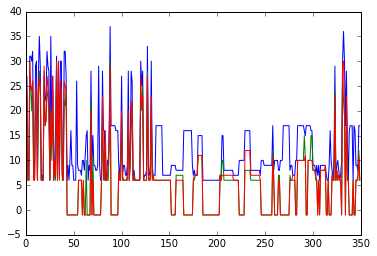

In [52]:
plt.plot(drug_profile_zip[3])
plt.plot(drug_profile_zip[7])
plt.plot(drug_profile_zip[10])
plt.show()

In [4]:
carbapenem_drug_profile_zip = drug_profile_zip[[3, 7, 10]]
carbapenem_susceptibily_threshold = np.array([2, 2, 2])
carbapenem_resistance_threshold = np.array([8, 8, 8])

In [4]:
carbapenem_drug_profile_zip[0]!=-1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
lines_carbapenem = []
temp = np.array(lines_gtable)
[lines_carbapenem.append(temp[carbapenem_drug_profile_zip[i]!=-1]) for i in range(3)]

In [9]:
lines_carbapenem = []
for drug_no in range(3):
    temp = []
    for idx, line in enumerate(lines_gtable[1:]):
        if(carbapenem_drug_profile_zip[drug_no][idx] != -1):
            temp.append(line)
    lines_carbapenem.append(temp)

In [10]:
len(lines_carbapenem), [len(line) for line in lines_carbapenem]

(3, [350, 230, 229])

In [ ]:
lines_carbapenem[0]

In [171]:
np.array([[(lambda x: False if x=='' else True)(x) for x in seq_gene] for seq_gene in genes_pa_small_zip[15:]]) #15+[]

array(['Gene', 'mepA', 'yciC', ..., 'group_6711', 'group_7239',
       'group_7874'], 
      dtype='<U519')

In [57]:
prokka_gff = read_file('../../Roary/GFF/PROKKA_03242017.gff')
prokka_gff[0]

'##gff-version 3\n'

In [58]:
len(prokka_gff)

69497

In [61]:
prokka_gff[0].startswith('#')

True

In [5]:
def get_comment_idx(file):
    return np.array([line.startswith('#') for line in file])

In [7]:
prokka_gff = read_file('../../Roary/GFF/PROKKA_03242017.gff')
comment_idx = get_comment_idx(prokka_gff)
print(np.where(comment_idx))
prokka_gff = np.array(prokka_gff)
prokka_gff[comment_idx]

(array([   0,    1, 3818]),)


array(['##gff-version 3\n', '##sequence-region gi_384129960 1 3940614\n',
       '##FASTA\n'], 
      dtype='<U353')

In [92]:
prokka_gff = np.array(prokka_gff)
prokka_gff[comment_idx]

array(['##gff-version 3\n', '##sequence-region gi_384129960 1 3940614\n',
       '##FASTA\n'], 
      dtype='<U353')

In [93]:
prokka_gff = prokka_gff[comment_idx==False]

In [94]:
len(prokka_gff), prokka_gff[0]

(69494,
 'gi_384129960\tProdigal:2.6\tCDS\t420\t1634\t.\t-\t0\tID=GCF_000188215_00001;eC_number=6.1.1.1;Name=tyrS;gene=tyrS;inference=ab initio prediction:Prodigal:2.6,similar to AA sequence:UniProtKB:P41256;locus_tag=GCF_000188215_00001;product=Tyrosine--tRNA ligase\n')

In [95]:
gff_fields = prokka_gff[0].split('\t')
gff_fields

['gi_384129960',
 'Prodigal:2.6',
 'CDS',
 '420',
 '1634',
 '.',
 '-',
 '0',
 'ID=GCF_000188215_00001;eC_number=6.1.1.1;Name=tyrS;gene=tyrS;inference=ab initio prediction:Prodigal:2.6,similar to AA sequence:UniProtKB:P41256;locus_tag=GCF_000188215_00001;product=Tyrosine--tRNA ligase\n']

In [107]:
pd.DataFrame(prokka_gff)

0
0      gi_384129960\tProdigal:2.6\tCDS\t420\t1634\t.\...
1      gi_384129960\tProdigal:2.6\tCDS\t1714\t2841\t....
2      gi_384129960\tProdigal:2.6\tCDS\t2969\t3814\t....
3      gi_384129960\tProdigal:2.6\tCDS\t3871\t4206\t....
4      gi_384129960\tProdigal:2.6\tCDS\t4331\t5335\t....
5      gi_384129960\tProdigal:2.6\tCDS\t5677\t6684\t....
6      gi_384129960\tProdigal:2.6\tCDS\t6940\t7944\t....
7      gi_384129960\tProdigal:2.6\tCDS\t8197\t10128\t...
8      gi_384129960\tProdigal:2.6\tCDS\t10379\t10936\...
9      gi_384129960\tProdigal:2.6\tCDS\t11022\t11414\...
10     gi_384129960\tProdigal:2.6\tCDS\t11452\t13920\...
11     gi_384129960\tProdigal:2.6\tCDS\t13973\t15055\...
12     gi_384129960\tProdigal:2.6\tCDS\t15070\t16218\...
13     gi_384129960\tProdigal:2.6\tCDS\t16316\t17713\...
14     gi_384129960\tProdigal:2.6\tCDS\t18384\t18518\...
15     gi_384129960\tProdigal:2.6\tCDS\t18548\t18940\...
16     gi_384129960\tProdigal:2.6\tCDS\t18951\t19271\...
17     gi_384129960\tProdigal:2.6\tCDS\t19277\t21037\...
18     gi_384129960\tProdigal:2.6\tCDS\t21128\t22483\...
19     gi_384129960\tProdigal:2.6\tCDS\t22529\t22792\...
20     gi_384129960\tProdigal:2.6\tCDS\t22850\t23830\...
21     gi_384129960\tProdigal:2.6\tCDS\t23926\t24624\...
22     gi_384129960\tProdigal:2.6\tCDS\t24677\t24928\...
23     gi_384129960\tProdigal:2.6\tCDS\t25101\t25628\...
24     gi_384129960\tProdigal:2.6\tCDS\t25731\t25880\...
25     gi_384129960\tProdigal:2.6\tCDS\t25843\t27168\...
26     gi_384129960\tProdigal:2.6\tCDS\t27225\t28280\...
27     gi_384129960\tProdigal:2.6\tCDS\t28571\t29731\...
28     gi_384129960\tProdigal:2.6\tCDS\t29753\t30118\...
29     gi_384129960\tProdigal:2.6\tCDS\t30307\t31263\...
...                                                  ...
69464  GTAAGGGCCATGATGACTTGACGTCGTCCCCGCCTTCCTCCAGTTT...
69465  CCTTAAAGTTCCCATCCGAAATGCTGGCAAGTAAGGAAAAGGGTTG...
69466  CTTAACCCAACATCTCACGACACGAGCTGACGACAGCCATGCAGCA...
69467  CCCGAAGGCACCAATCCATCTCTGGAAAGTTTCTAGTATGTCAAGG...
69468  TCGCGTTGCATCGAATTAAACCACATGCTCCACCGCTTGTGCGGGC...
69469  TTGAGTTTTAGTCTTGCGACCGTACTCCCCAGGCGGTCTACTTATC...
69470  ACTAAAGCCTCAAAGGCCCCAACGGCTAGTAGACATCGTTTACGGC...
69471  TATCTAATCCTGTTTGCTCCCCATGCTTTCGTACCTCAGCGTCAGT...
69472  CTGCCTTCGCCATCGGTATTCCTCCAGATCTCTACGCATTTCACCG...
69473  CTACCATCCTCTCCCATACTCTAGCTCACCAGTATCGAATGCAATT...
69474  GGGGATTTCACATCCGACTTAATAAGCCGCCTACGCACGCTTTACG...
69475  TTAACGCTCGCACCCTCTGTATTACCGCGGCTGCTGGCACAGAGTT...
69476  CTGCGAGTAACGTCCACTATCCCTAGGTATTAACTAGAGTAGCCTC...
69477  TGCTTTACAACCATAAGGCCTTCTTCACACACGCGGCATGGCTGGA...
69478  ATTGTCCAATATTCCCCACTGCTGCCTCCCGTAGGAGTCTGGGCCG...
69479  TGTGGCGGATCATCCTCTCAGACCCGCTACAGATCGTCGCCTTGGT...
69480  CCAACTAGCTAATCCGACTTAGGCTCATCTATTAGCGCAAGGTCCG...
69481  TCTCCCGTAGGACGTATGCGGTATTAGCATCCCTTTCGAGATGTTG...
69482  GCAGATTCCTAAGCATTACTCACCCGTCCGCCGCTAGGTCCAGTAG...
69483  CCGCTCGACTTGCATGTGTTAAGCCTGCCGCCAGCGTTCAATCTGA...
69484  CTTCAGTTAAAATCATTTTGCACCTTATTTATAGACAAGGTGCCAA...
69485  TTACTGACTTAAATTTCGCTCAAATAAACTTCGAGTAATTTAAACC...
69486  AATTATTTCGATTAATCAATCAGTAAAAATCCACACAAGTTGTTCT...
69487  GATCTTCTTACTGGTTCGTCACCAGCAAGCTAGGTCGGCTATATTA...
69488  AAAGTCAACAGGTAATTTCGATATTTTTAAAACTCATTCTCTAAAC...
69489  ATTCATCACTTAAAGCAACCAATCTAATCACAAGTAACTGTTTTTC...
69490  TGCATCACCGCCGATGGATGTGCATTATAGACCATTAATAACCCTT...
69491  ATCCCTTTTTCACTTGAGTGCCGTTTTTTTCTACTATTTTGCGAAA...
69492  GGCTTTTTTTTAGGCATTTTTGCTATTTTTTATTGGTTTTTATCTT...
69493  TTTTGGAGTTAGGGAGTCTTTTATATGGTTTTTATTCCTCTATAAG...

[69494 rows x 1 columns]

In [12]:
gff_table = pd.read_table('../../Roary/GFF/PROKKA_03242017.gff', skiprows=2, nrows=3815, header=None, index_col=[3,4])
gff_table.head()

0             1    2  5  6  7  \
3    4                                                
420  1634  gi_384129960  Prodigal:2.6  CDS  .  -  0   
1714 2841  gi_384129960  Prodigal:2.6  CDS  .  +  0   
2969 3814  gi_384129960  Prodigal:2.6  CDS  .  +  0   
3871 4206  gi_384129960  Prodigal:2.6  CDS  .  -  0   
4331 5335  gi_384129960  Prodigal:2.6  CDS  .  -  0   

                                                           8  
3    4                                                        
420  1634  ID=GCF_000188215_00001;eC_number=6.1.1.1;Name=...  
1714 2841  ID=GCF_000188215_00002;eC_number=2.7.1.170;Nam...  
2969 3814  ID=GCF_000188215_00003;eC_number=3.3.2.10;Name...  
3871 4206  ID=GCF_000188215_00004;Name=erpA;gene=erpA;inf...  
4331 5335  ID=GCF_000188215_00005;inference=ab initio pre...

In [134]:
gff_table.loc[420,1634]

0                                         gi_384129960
1                                         Prodigal:2.6
2                                                  CDS
5                                                    .
6                                                    -
7                                                    0
8    ID=GCF_000188215_00001;eC_number=6.1.1.1;Name=...
Name: (420, 1634), dtype: object

In [136]:
np.sort(gff_table.index)

array([(420, 1634), (1714, 2841), (2969, 3814), ..., (3934994, 3937883),
       (3938226, 3938301), (3938357, 3938433)], dtype=object)

In [144]:
print(sum(np.sort(list(zip(*gff_table.index))[0]) - np.array(list(zip(*gff_table.index))[0])))
start_idx = np.array(list(zip(*gff_table.index))[0])
start_idx

0


array([    420,    1714,    2969, ..., 3934994, 3938226, 3938357])

In [143]:
import bisect

In [151]:
snp_temp_idx = 1500
bsearch_idx = bisect.bisect_right(start_idx, snp_temp_idx)
print(bsearch_idx)
bsearch_idx -= 1
print(bsearch_idx)
print(gff_table.index[bsearch_idx])
#is SNP inside a gene
print(snp_temp_idx<=gff_table.index[bsearch_idx][1])
#is SNP inside an upstream/promoter region
next_gene_start = gff_table.index[bsearch_idx+1][0]
promoter_region_size = 200
print(np.logical_and((next_gene_start-promoter_region_size)<=snp_temp_idx, snp_temp_idx<next_gene_start))
#else SNP region is unknown (could possibly be in the non-coding region)

1
0
(420, 1634)
True
False
